<a href="https://colab.research.google.com/github/clareokafor/Bitcoin-Future-Prices-Using-Machine-Learning-Models/blob/main/Ogochukwu_Okafor_201666459_BitcoinPricePrediction_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BITCOIN PRICE PREDICTION


**BY OGOCHUKWU OKAFOR**

**Importing Relevant Libraries**

In [ ]:
%%capture
!pip install tensorflow;

# General data manipulation and visualization
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.exceptions import ConvergenceWarning

# Scikit-learn models
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# TensorFlow and Keras for neural networks
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Other utilities
import random
import time
import warnings
import warnings
from warnings import simplefilter
from joblib import dump

# Suppress warnings (optional), makes the printouts to be very lengthy
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Data Collection and Preparation**

**Defining Functions for:**


1.   Data Collection (Getting the Historical Bitcoin Data)
2.   Data Processing
3.   Normalisation

In [ ]:
def GetHistoricalBTCData(start_date, end_date):
  # Retrieving the historical stock price data of Bitcoin-GBP from Yahoo Finance API
  bitcoin = yf.download("BTC-GBP", start=start_date, end=end_date)
  return bitcoin

def DataPreprocessing(data):
  # Dropping any rows with missing values
  data.dropna(inplace=True)

  # Extracting features
  features = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
  return features

def Normalisation(features, target=None):
  # Initialising the scaler for features
  scaler_X = MinMaxScaler()

  # Fitting the scaler to the features and transforming them
  scaled_features = pd.DataFrame(scaler_X.fit_transform(features), columns=features.columns, index=features.index)

  if target is not None:
    scaler_y = MinMaxScaler() # Initialising the scaler for the target

    # Fitting the scaler to the target and transforming it
    scaled_target = pd.DataFrame(scaler_y.fit_transform(target.values.reshape(-1,1)), columns=[target.name], index=target.index)
    return scaled_features, scaled_target, scaler_X, scaler_y # Returning scaled features, scaled target, and the scalers

  # If there is no target, return only the scaled features and the scaler for features
  return scaled_features, scaler_X

1. Specifying the Time Frame for Data Collection
2. Loading the Data

In [ ]:
# Loading the historical stock price data from Yahoo Finance API for Bitcoin-GBP
start_date = "2015-01-01"

# end_date = "2023-09-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

bitcoin_gbp = GetHistoricalBTCData(start_date, end_date)

# Pre-processing the data and extract relevant features
bitcoin = DataPreprocessing(bitcoin_gbp)

[*********************100%%**********************]  1 of 1 completed


Printing some samples of the preprocessed data

In [ ]:
some_sample = bitcoin.head(10)
some_sample.to_string(formatters={'Volume': '{:,}'.format})
some_sample = bitcoin.head(10).style.format({'Volume': '{:,}'})
some_sample

Printing the last 10 samples of the preprocessed data

In [ ]:
tail_sample = bitcoin.tail(10)
tails = bitcoin.tail(10).style.format({'Volume': '{:,}'})
tails

Printing some samples of the preprocessed data randomly

In [ ]:
random_sample = bitcoin.sample(n=10, random_state=42)
random_sample = random_sample.style.format({'Volume': '{:,}'})
random_sample

Printing the Data Information

In [ ]:
print("Information about extracted features:")
print(bitcoin.info())

Information about extracted features:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3165 entries, 2015-01-01 to 2023-08-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3165 non-null   float64
 1   High       3165 non-null   float64
 2   Low        3165 non-null   float64
 3   Close      3165 non-null   float64
 4   Adj Close  3165 non-null   float64
 5   Volume     3165 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 173.1 KB
None


Visualising the Historical Data of Bitcoin Prices

In [ ]:
# Creating traces for the first subplot (price)
trace_open = go.Scatter(x=bitcoin.index, y=bitcoin['Open'], mode='lines', name='Open', line=dict(color='red'))
trace_high = go.Scatter(x=bitcoin.index, y=bitcoin['High'], mode='lines', name='High', line=dict(color='black'))
trace_low = go.Scatter(x=bitcoin.index, y=bitcoin['Low'], mode='lines', name='Low', line=dict(color='orange'))
trace_close = go.Scatter(x=bitcoin.index, y=bitcoin['Close'], mode='lines', name='Close', line=dict(color='green'))
trace_adj_close = go.Scatter(x=bitcoin.index, y=bitcoin['Adj Close'], mode='lines', name='Adj Close', line=dict(color='blue'))

# Creating the first subplot (price)
subplot1 = go.Figure(data=[trace_open, trace_high, trace_low, trace_close, trace_adj_close])
subplot1.update_layout(
    title='Bitcoin (BTC) Price (£)',
    xaxis_title='Date(Year)',
    yaxis_title='Price',
    height=500,
    width=900
)
subplot1.show() # Displaying the plot

# Creating traces for the second subplot (volume)
trace_volume = go.Scatter(x=bitcoin.index, y=bitcoin['Volume'], mode='lines', name='Volume', line=dict(color='green'))

# Creating the second subplot (volume)
subplot2 = go.Figure(data=[trace_volume])
subplot2.update_layout(
    title='Bitcoin (BTC) Volume',
    xaxis_title='Date (Year)',
    yaxis_title='Volume',
    height=500,
    width=900
)
subplot2.show() # Displaying the plot

Visualising only the Closing Price of the Bitcoin-GBP Data

In [ ]:
# Creating a trace for the line plot
trace_close = go.Scatter(x=bitcoin.index, y=bitcoin['Close'], mode='lines', name='Close', line=dict(color='blue'))

# Creating the figure with the trace
fig = go.Figure(data=[trace_close])

# Setting the layout for the figure
fig.update_layout(
    title='Bitcoin Price (£)',
    xaxis_title='Date (Year)',
    yaxis_title='Price',
    height=500,
    width=900,
    showlegend=True
)
# Displaying the plot
fig.show()

Visualising the BTC Data in Candle Sticks

In [ ]:
# Creating a Figure object using the Candlestick chart type from the go module
# The x-axis is set to the index of the 'bitcoin' DataFrame
# The open, high, low, and close prices are all set to the 'Close' column of the 'bitcoin' DataFrame
fig = go.Figure(data=[go.Candlestick(x=bitcoin.index,
                      open=bitcoin['Close'],
                      high=bitcoin['Close'],
                      low=bitcoin['Close'],
                      close=bitcoin['Close'])])

# Adding layout configurations to the Figure object
# Setting the title, x-axis label, and y-axis label
fig.update_layout(
                  title='Bitcoin (BTC) Price (£) Candlestick Chart',  # Setting the title of the plot
                  xaxis_title='Date (Year)',  # Setting the title for the x-axis
                  yaxis_title='Price (£)',  # Setting the title for the y-axis

# Setting the dimensions of the plot (height and width)
  height=800,  # Setting the height of the plot to 600 units
  width=1200  # Setting the width of the plot to 1200 units
)

# Displaying the Figure object as a plot
fig.show()

Visualisation the First Year Bitcoin Price Information (Open vs Close Price)

In [ ]:
# Defining the start and end dates for the data query, limited to the year 2015
start_date = "2015-01-01"
end_date = "2015-12-31"

# Calling the function GetHistoricalBTCData to fetch historical Bitcoin data between the specified start and end dates
bitcoin = GetHistoricalBTCData(start_date, end_date)

# Grouping the Bitcoin data by month and calculating the mean 'Open' price for each month
month_open = bitcoin.groupby(bitcoin.index.strftime('%B'))['Open'].mean()

# Grouping the Bitcoin data by month and calculating the mean 'Close' price for each month
month_close = bitcoin.groupby(bitcoin.index.strftime('%B'))['Close'].mean()

# Defining the order of months for reindexing
calendar = ['January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December']

# Reindexing the month_open and month_close Series to ensure the data follows the calendar month order
month_open = month_open.reindex(calendar, axis=0)
month_close = month_close.reindex(calendar, axis=0)

# Initialising a Figure object for plotting
fig_open_close = go.Figure()

# Adding a Bar trace for 'Open Price' to the Figure object
# x-axis represents the months and y-axis represents the mean 'Open' prices
fig_open_close.add_trace(go.Bar(
  x=month_open.index,
  y=month_open,
  name='Open Price',  # Legend name for the bar
  marker_color='rgb(0, 153, 204)'  # A customized color for the bar
))

# Adding another Bar trace for 'Close Price' to the Figure object
# x-axis represents the months and y-axis represents the mean 'Close' prices
fig_open_close.add_trace(go.Bar(
  x=month_close.index,
  y=month_close,
  name='Close Price',  # Legend name for the bar
  marker_color='rgb(255, 128, 0)'  # A customized color for the bar
))

# Updating the layout of the Figure object to include titles, axis labels, and bar mode
fig_open_close.update_layout(barmode='group',  # Displaying bars for 'Open' and 'Close' side-by-side for each month
                             title='Year 2015 Open and Close Prices of Bitcoin',  # Set the title of the plot
                             xaxis_title='Month',  # Setting  the x-axis title
                             yaxis_title='Price (£)')  # Setting the y-axis title
# Displaying the plot
fig_open_close.show()

[*********************100%%**********************]  1 of 1 completed


Visualisation the First Year Bitcoin Price Information (High vs Low Price)

In [ ]:
# Grouping the Bitcoin data by month and find the maximum 'High' price for each month
month_high = bitcoin.groupby(bitcoin.index.strftime('%B'))['High'].max()

# Grouping the Bitcoin data by month and find the minimum 'Low' price for each month
month_low = bitcoin.groupby(bitcoin.index.strftime('%B'))['Low'].min()

# Reindexing the month_high Series to ensure the data follows the calendar month order
month_high = month_high.reindex(calendar, axis=0)

# Reindexing the month_low Series to ensure the data follows the calendar month order
month_low = month_low.reindex(calendar, axis=0)

# Initialising a new Figure object for plotting the high and low prices
fig_high_low = go.Figure()

# Adding a Bar trace for 'High Price' to the Figure object
# x-axis represents the months, and y-axis represents the maximum 'High' prices
fig_high_low.add_trace(go.Bar(
    x=month_high.index,  # Months as x-axis labels
    y=month_high,  # Maximum high prices as y-values
    name='High Price',  # Legend name for the bar
    marker_color='rgb(0, 153, 204)'  # A customised color for the bar
))

# Adding another Bar trace for 'Low Price' to the Figure object
# x-axis represents the months, and y-axis represents the minimum 'Low' prices
fig_high_low.add_trace(go.Bar(
    x=month_low.index,  # Months as x-axis labels
    y=month_low,  # Minimum low prices as y-values
    name='Low Price',  # Legend name for the bar
    marker_color='rgb(255, 128, 0)'  # A customised color for the bar
))

# Updating the layout of the Figure
fig_high_low.update_layout(barmode='group',  # Displaying bars for 'High' and 'Low' side-by-side for each month
                           title='Year 2015 High and Low Prices of Bitcoin',  # Setting the title of the plot
                           xaxis_title='Month',  # Setting the x-axis title
                           yaxis_title='Price (£)')  # Setting the y-axis title

# Displaying the plot
fig_high_low.show()

Visualisation the Year 2023 Bitcoin Price Information (Open vs Close Price)

In [ ]:
# Defining the start and end dates for the data query, limited to the year 2023
start_date = "2023-01-01"
end_date = "2023-12-31"

# Calling the function GetHistoricalBTCData to fetch historical Bitcoin data between the specified start and end dates
bitcoin = GetHistoricalBTCData(start_date, end_date)

# Grouping the Bitcoin data by month and calculating the mean 'Open' price for each month
month_open = bitcoin.groupby(bitcoin.index.strftime('%B'))['Open'].mean()

# Grouping the Bitcoin data by month and calculating the mean 'Close' price for each month
month_close = bitcoin.groupby(bitcoin.index.strftime('%B'))['Close'].mean()

# Defining the order of months for reindexing
calendar = ['January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December']

# Reindexing the month_open and month_close Series to ensure the data follows the calendar month order
month_open = month_open.reindex(calendar, axis=0)
month_close = month_close.reindex(calendar, axis=0)

# Initialising a Figure object for plotting
fig_open_close = go.Figure()

# Adding a Bar trace for 'Open Price' to the Figure object
# x-axis represents the months and y-axis represents the mean 'Open' prices
fig_open_close.add_trace(go.Bar(
  x=month_open.index,
  y=month_open,
  name='Open Price',  # Legend name for the bar
  marker_color='rgb(0, 153, 204)'  # A customized color for the bar
))

# Adding another Bar trace for 'Close Price' to the Figure object
# x-axis represents the months and y-axis represents the mean 'Close' prices
fig_open_close.add_trace(go.Bar(
  x=month_close.index,
  y=month_close,
  name='Close Price',  # Legend name for the bar
  marker_color='rgb(255, 128, 0)'  # A customized color for the bar
))

# Updating the layout of the Figure
fig_open_close.update_layout(barmode='group',  # Displaying bars for 'Open' and 'Close' side-by-side for each month
                             title='Year 2023 Open and Close Prices of Bitcoin',  # Setting the title of the plot
                             xaxis_title='Month',  # Setting  the x-axis title
                             yaxis_title='Price (£)')  # Setting the y-axis title
# Displaying the plot
fig_open_close.show()

[*********************100%%**********************]  1 of 1 completed


Visualisation the Year 2023 Bitcoin Price Information (High vs Low Price)

In [ ]:
# Grouping the Bitcoin data by month and find the maximum 'High' price for each month
month_high = bitcoin.groupby(bitcoin.index.strftime('%B'))['High'].max()

# Grouping the Bitcoin data by month and find the minimum 'Low' price for each month
month_low = bitcoin.groupby(bitcoin.index.strftime('%B'))['Low'].min()

# Reindexing the month_high Series to ensure the data follows the calendar month order
month_high = month_high.reindex(calendar, axis=0)

# Reindexing the month_low Series to ensure the data follows the calendar month order
month_low = month_low.reindex(calendar, axis=0)

# Initialising a a figure for plotting the high and low prices
fig_high_low = go.Figure()

# Adding a Bar trace for 'High Price' to the Figure object
# x-axis represents the months, and y-axis represents the maximum 'High' prices
fig_high_low.add_trace(go.Bar(
    x=month_high.index,  # Months as x-axis labels
    y=month_high,  # Maximum high prices as y-values
    name='High Price',  # Legend name for the bar
    marker_color='rgb(0, 153, 204)'  # A customised color for the bar
))

# Adding another Bar trace for 'Low Price' to the Figure object
# x-axis represents the months, and y-axis represents the minimum 'Low' prices
fig_high_low.add_trace(go.Bar(
    x=month_low.index,  # Months as x-axis labels
    y=month_low,  # Minimum low prices as y-values
    name='Low Price',  # Legend name for the bar
    marker_color='rgb(255, 128, 0)'  # A customised color for the bar
))

# Updating the layout of the Figure
fig_high_low.update_layout(barmode='group',  # Displaying bars for 'High' and 'Low' side-by-side for each month
                           title='Year 2023 High and Low Prices of Bitcoin',  # Setting the title of the plot
                           xaxis_title='Month',  # Setting the x-axis title
                           yaxis_title='Price (£)')  # Setting the y-axis title

# Displaying the plot
fig_high_low.show()

Visualising the Bitcoin Prices in a Box Plot

In [ ]:
# Defining a list to hold the 'Open', 'High', 'Low', 'Close', and 'Adj Close' prices feature columns.
feature_plot = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Initialising an empty list to store the box plot traces
box_traces = []

# Looping over each price in the feature_plot list
for f in feature_plot:
  # Creating a Box trace for each feature column in the 'bitcoin' DataFrame
  # 'y' contains the data for the box plot, and 'name' sets the legend name for the trace
  trace = go.Box(y=bitcoin[f], name=f)

  # Appending the newly created Box trace to the box_traces list
  box_traces.append(trace)

# Creating the layout and setting the title and y-axis label
layout = go.Layout(
    title="Box Plot of Bitcoin Price Features",  # Title of the plot
    yaxis=dict(title="Price")  # Title for the y-axis
)

# Creating the box_traces for data and the predefined layout
fig = go.Figure(data=box_traces, layout=layout)

# Displaying the plot
fig.show()

Bitcoin Data Shape

In [ ]:
bitcoin.shape

(3165, 6)

Checking for Null Values

In [ ]:
bitcoin.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Dropping Adj Close column since it has the same values with Close column

In [ ]:
# Loading the data again
start_date = "2015-01-01"

# end_date = "2023-09-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

bitcoin_gbp = GetHistoricalBTCData(start_date, end_date)

# Calling the data processing function again
bitcoin = DataPreprocessing(bitcoin_gbp)

# Dropping the "Adj Close" column in order to avoid redundancy since it is identical/same values to the "Close" column
bitcoin = bitcoin.drop("Adj Close", axis=1)

# Checking if "Adj Close" column has been effectively dropped.
random_check = bitcoin.sample(n=10, random_state=42)
random_check = random_check.style.format({'Volume': '{:,}'})
random_check

[*********************100%%**********************]  1 of 1 completed


**Data Splitting**

In [ ]:
# Setting a fixed seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Data Splitting - Splitting the dataset into training and testing sets (80% for training, 20% for testing)
X = bitcoin.drop("Close", axis=1)  # All features except 'Close' (target variable)
y = bitcoin["Close"]  # Target variable 'Close'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normalising the Splitted Datasets

In [ ]:
# Normalising the splitted train and test datasets
X_train_norm, y_train_norm, scaler_X_train, scaler_y_train = Normalisation(X_train, y_train) # Training data
X_test_norm, y_test_norm, scaler_X_test, scaler_y_test = Normalisation(X_test, y_test) # Testing data

Printing the Information of the Normalised Datasets that will be used for the Analysis

In [ ]:
line = '_'* 50
print("Information about the normalized training features:")
print(X_train_norm.info())
print(line)

print("\nInformation about the normalized training target:")
print(y_train_norm.info())
print(line)

print("\nInformation about the normalized testing features:")
print(X_test_norm.info())
print(line)

print("\nInformation about the normalized testing target:")
print(y_test_norm.info())

Information about the normalized training features:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2022-03-23 to 2017-05-10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2532 non-null   float64
 1   High    2532 non-null   float64
 2   Low     2532 non-null   float64
 3   Volume  2532 non-null   float64
dtypes: float64(4)
memory usage: 98.9 KB
None
__________________________________________________

Information about the normalized training target:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2022-03-23 to 2017-05-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2532 non-null   float64
dtypes: float64(1)
memory usage: 39.6 KB
None
__________________________________________________

Information about the normalized testing features:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 633 entries, 2022

In [ ]:
print("Normalised Training Data Features and Target:")
X_train_norm, y_train_norm

Normalised Training Data Features and Target:


(                Open      High       Low    Volume
 Date                                              
 2022-03-23  0.640276  0.637852  0.643166  0.075855
 2018-01-02  0.200398  0.221350  0.197108  0.049174
 2016-11-13  0.008585  0.008283  0.008862  0.000233
 2017-11-18  0.114623  0.114957  0.113334  0.010998
 2016-09-29  0.006659  0.006459  0.007201  0.000150
 ...              ...       ...       ...       ...
 2023-06-20  0.410529  0.413601  0.417783  0.039778
 2017-12-31  0.189501  0.207317  0.191128  0.035669
 2018-02-04  0.128153  0.127630  0.114236  0.019879
 2018-07-18  0.109730  0.111093  0.111707  0.018506
 2017-05-10  0.024631  0.024523  0.024820  0.002791
 
 [2532 rows x 4 columns],
                Close
 Date                
 2022-03-23  0.651231
 2018-01-02  0.219432
 2016-11-13  0.008883
 2017-11-18  0.116302
 2016-09-29  0.007050
 ...              ...
 2023-06-20  0.419980
 2017-12-31  0.208684
 2018-02-04  0.115685
 2018-07-18  0.111064
 2017-05-10  0.025465
 
 [2532 r

In [ ]:
print("Normalised Testing Data Features and Target:")
X_test_norm, y_test_norm

Normalised Testing Data Features and Target:


(                Open      High       Low    Volume
 Date                                              
 2022-03-03  0.684814  0.678769  0.664775  0.265074
 2015-12-13  0.003512  0.003023  0.003485  0.000441
 2015-06-20  0.000793  0.000216  0.000752  0.000111
 2015-12-21  0.003793  0.003197  0.003623  0.000666
 2019-04-08  0.081163  0.081504  0.081343  0.186125
 ...              ...       ...       ...       ...
 2021-10-13  0.862697  0.872384  0.845242  0.432297
 2022-02-05  0.640121  0.637710  0.641510  0.205744
 2021-11-02  0.933368  0.974851  0.941610  0.392922
 2021-10-29  0.918472  0.950475  0.926322  0.381765
 2021-12-02  0.900862  0.889374  0.890151  0.345103
 
 [633 rows x 4 columns],
                Close
 Date                
 2022-03-03  0.660706
 2015-12-13  0.003146
 2015-06-20  0.000409
 2015-12-21  0.003333
 2019-04-08  0.081695
 ...              ...
 2021-10-13  0.873490
 2022-02-05  0.635950
 2021-11-02  0.966040
 2021-10-29  0.946036
 2021-12-02  0.883307
 
 [633 row

**A Generic Function for Calculating Perfomance Metrics of the Models**

In [ ]:
def CalculateMetrics(y_true, y_pred):
  """
  This function will calculate various performance metrics given true and predicted values.

  Parameters:
    y_true (array-like): Array of true values.
    y_pred (array-like): Array of predicted values.

  Returns:
    dict: A dictionary containing the six performance metrics.
  """
  # Calculating the six evaluation metrics and store them in a dictionary
  results = {
    'R2': r2_score(y_true, y_pred),
    'MSE': mean_squared_error(y_true, y_pred),
    'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error(y_true, y_pred),
    'MedianAE': median_absolute_error(y_true, y_pred),
    'ExplainedVariance': explained_variance_score(y_true, y_pred)}
  return results

**A Generic Function for Performing Grid Search Cross Validation for the Models**

In [ ]:
y_train_norm = np.array(y_train_norm).ravel()
y_test_norm = np.array(y_test_norm).ravel()

def PerformGridSearch(model, param_grid, X_train_norm, y_train_norm, cv=5):
  """
  This function will perform grid search to find the best model based on given parameters.

  Parameters:
    model (estimator object): The model to be trained.
    param_grid (dict): Dictionary with parameters names as keys and lists of parameter settings to try as values.
    X_train_norm (array-like): The features for the training set.
    y_train_norm (array-like): The labels for the training set.
    cv (int, default=5): Number of cross-validation folds.

  Returns:
    best_model (estimator object): The model with the best hyperparameters.
    training_time (float): Time taken for training the model.
  """
  start_time = time.time()  # Recording the start time for training

  # Suppressing warnings related to ConvergenceWarning (optional)
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Performing grid search with 5-fold cross-validation
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')
    #grid_search.fit(X_train_norm, y_train_norm.values.flatten())
    grid_search.fit(X_train_norm, y_train_norm)

  end_time = time.time() # Recording the end time for training
  training_time = end_time - start_time # Calculating the total time taken for training
  best_model = grid_search.best_estimator_ # Extracting the best model from grid search

  return best_model, training_time

**A Generic Print Function for the Models**

In [ ]:
def PrintResults(model_name, best_model, train_metrics, test_metrics, training_time):
  """
  Print the model name, best hyperparameters, and performance metrics.

  Parameters:
    model_name (str): The name of the model.
    best_model (estimator object): The model with the best hyperparameters.
    train_metrics (dict): Training metrics.
    test_metrics (dict): Testing metrics.
    training_time (float): Time taken for training the model.
  """

  print(f"{model_name} Model:") # Printing the name of the model
  print("Best Hyperparameters:", best_model.get_params())  # Printing the best hyperparameters

  # Printing a line for separation
  line = "_" * 50
  print(line)

  # Printing the training metrics
  print("Training Metrics:")
  for key, value in train_metrics.items():
    print(f"Train {key}: {value}")
  print(line)  # Printing a line for separation

  # Printing the testing metrics
  print("Testing Metrics:")
  for key, value in test_metrics.items():
    print(f"Test {key}: {value}")
  print(line)  # Printing a line for separation

  # Converting training time to minutes and print
  training_time_minutes = training_time / 60
  print(f"{model_name} Training Time: {training_time_minutes:.2f} minutes")

**A Generic Function for the Predicted vs Actual Plots for Each Model**

In [ ]:
def PredictedVsActualPlots(y_actual, y_predicted, model_name):
  """
  A generic scatter plots to compare predicted vs actual values for each model.

  Args:
  - y_actual (array-like): Array or list of actual target values.
  - y_predicted (array-like): Array or list of predicted target values from the model.
  - model_name (str): The name of the machine learning model used for prediction.

  Returns:
  - None: The function displays a scatter plot.
  """
  # Flattening y_actual to convert it to a 1D array for plotting
  y_actual_flattened = np.array(y_actual).flatten()

  # Creating a figure for plotting
  plt.figure(figsize=(8, 6))
  plt.scatter(y_actual_flattened, y_predicted, alpha=0.5) # Scatter plot of actual vs predicted values
  coef = np.polyfit(y_actual_flattened, y_predicted, 1) # Performing a simple linear regression on the data and get the coefficients
  poly1d_fn = np.poly1d(coef) # Creating a 1D polynomial function using the coefficients

  # Plotting the best-fit linear regression line
  plt.plot(y_actual_flattened, poly1d_fn(y_actual_flattened), color='red', linewidth=2)
  plt.xlabel('Actual') # Labelling the x-axis as 'Actual'
  plt.ylabel('Predicted')  # Labelling the y-axis as 'Predicted'
  plt.title(f'{model_name} - Predicted vs Actual') # Adding a title to the plot
  plt.grid() # Adding a grid for easier reading of the plot
  plt.show() # Displaying the plot

**A Generic Function for the Residual Plots for Each Model**

In [ ]:
def ResidualPlots(y_actual, y_predicted, model_name):
  """
  A generic residual plots for a given predictive model.

  Parameters:
  - y_actual (array-like or pd.Series): Array of actual target values.
  - y_predicted (array-like): Array of predicted target values.
  - model_name (str): String denoting the name of the model.

  Returns:
  - None: Displays a residual plot using plotly.
  """
  # Flattening the y_actual values to a 1D array for consistency
  y_actual_flattened = np.array(y_actual).flatten()

  # Calculating the residuals by subtracting predicted values from actual values
  residuals = y_actual_flattened - y_predicted
  fig = go.Figure() # Initialising the Plotly figure object

  # Adding scatter plot trace for residuals
  fig.add_trace(go.Scatter(x=y_predicted, y=residuals, mode='markers', name='Residuals',
                          marker=dict(size=5, opacity=0.5)))
  # Adding a horizontal line at y=0 to indicate the zero residual line
  fig.add_shape(
    go.layout.Shape(
      type='line',
      x0=min(y_predicted),
      x1=max(y_predicted),
      y0=0,
      y1=0,
      line=dict(color='red', dash='dash')
      ))
  # Configuring layout parameters including titles and axis labels
  fig.update_layout(title=f'{model_name} - Residuals Plot',
                    xaxis_title='Predicted',
                    yaxis_title='Residuals',
                    showlegend=True)
  # Displaying the plot
  fig.show()

**Building and Executing Artificial Neural Networks**

1. MLP (Multi-Layer Perceptron)

MLP Model:
Best Hyperparameters: {'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (75,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 1, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
__________________________________________________
Training Metrics:
Train R2: 0.8821446222921676
Train MSE: 0.006857421200217358
Train RMSE: 0.08280954776000989
Train MAE: 0.06883664319001537
Train MedianAE: 0.06319460064906439
Train ExplainedVariance: 0.8824000360173143
__________________________________________________
Testing Metrics:
Test R2: 0.8995019263679677
Test MSE: 0.00591357053597512
Test RMSE: 0.07689974340643226
Test MAE: 0.06748958463179473
Test MedianAE: 0.07009940

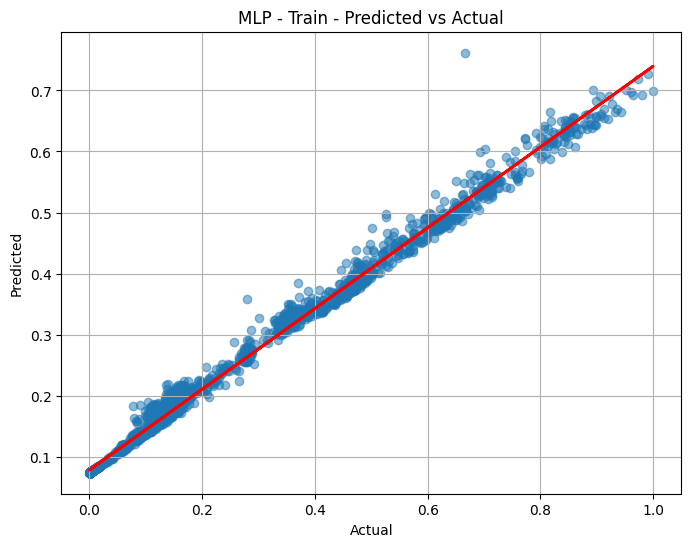

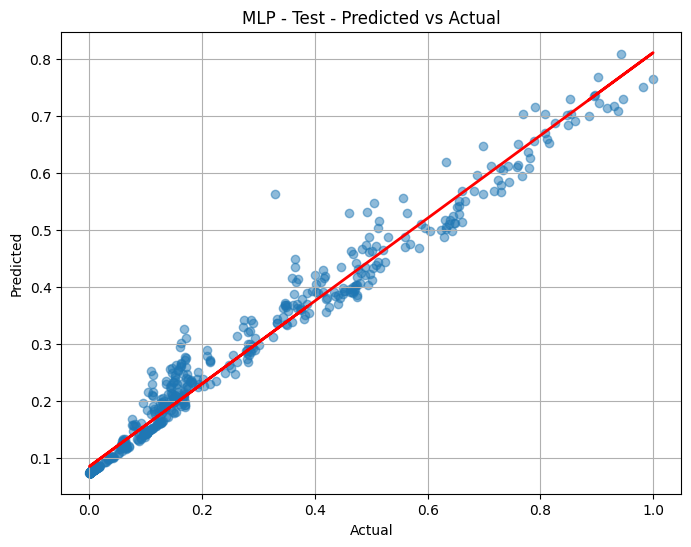

In [ ]:
# Setting a fixed seed for reproducibility
np.random.seed(42)
random.seed(42)

# Initialising the MLPRegressor model
mlp = MLPRegressor(random_state=42)

# Defining the hyperparameter grid for MLP
mlp_params = {
  'hidden_layer_sizes': [(50,), (75,), (100),],  # Sizes of the hidden layers
  'activation': ['logistic', 'identity'],  # Activation functions to try
  'learning_rate_init': [0.01, 0.1],  # The initial learning rate
  'max_iter': [1, 2],  # Maximum number of iterations for the solver
}

# Performing grid search optimization for the MLP model
best_mlp, mlp_train_time = PerformGridSearch(mlp, mlp_params, X_train_norm, y_train_norm)

# Calculating the performance metrics for training and testing data using the best_mlp model
mlp_train_metrics = CalculateMetrics(y_train_norm, best_mlp.predict(X_train_norm))
mlp_test_metrics = CalculateMetrics(y_test_norm, best_mlp.predict(X_test_norm))

# Printing the results
PrintResults("MLP", best_mlp, mlp_train_metrics, mlp_test_metrics, mlp_train_time)

dump(best_mlp, 'best_mlp_model.joblib')

# Visualising the PredictdVsActualPlots and Residual Plots
PredictedVsActualPlots(y_train_norm, best_mlp.predict(X_train_norm), "MLP - Train") # For the training data
PredictedVsActualPlots(y_test_norm, best_mlp.predict(X_test_norm), "MLP - Test") # For the test data

ResidualPlots(y_train_norm, best_mlp.predict(X_train_norm), "MLP - Train") # For the training data
ResidualPlots(y_test_norm,best_mlp.predict(X_test_norm), "MLP - Test") # For the test data

2. Long-Term Short Memory

LSTM Model:
Best Hyperparameters: {'verbose': 0, 'batch_size': 16, 'dropout': 0.1, 'epochs': 2, 'hidden_units': 100, 'optimizer': 'adam', 'build_fn': <function LSTMModel at 0x7f2b6f3ae560>}
__________________________________________________
Training Metrics:
Train R2: 0.817283210953225
Train MSE: 0.010631385747633375
Train RMSE: 0.10310861141356417
Train MAE: 0.07746510218318696
Train MedianAE: 0.06186654819766327
Train ExplainedVariance: 0.8212832102024697
__________________________________________________
Testing Metrics:
Test R2: 0.86128113252569
Test MSE: 0.008162582404151181
Test RMSE: 0.09034701104160105
Test MAE: 0.07451894391265063
Test MedianAE: 0.06596501833248863
Test ExplainedVariance: 0.8698978478318871
__________________________________________________
LSTM Training Time: 11.26 minutes


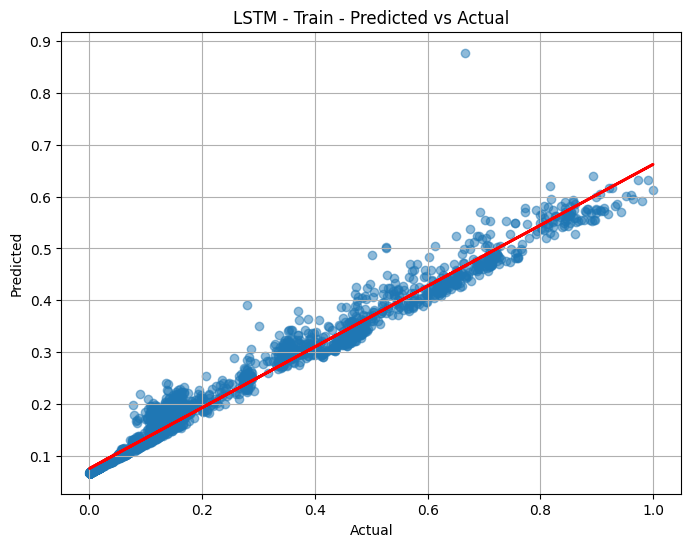

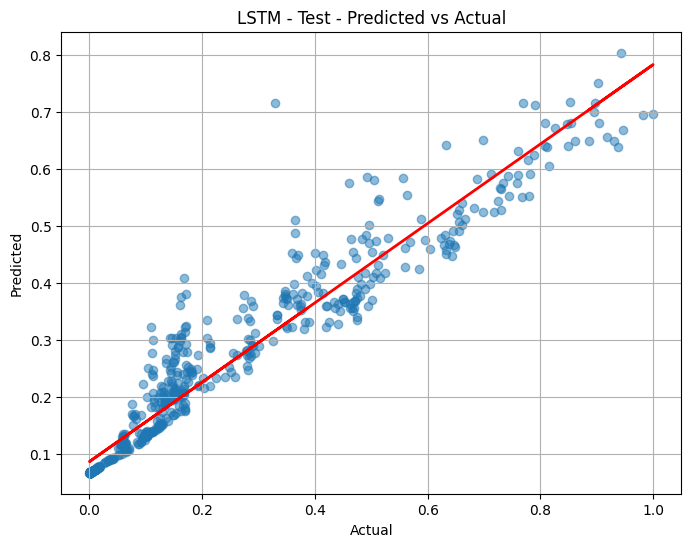

In [ ]:
# Suppressing deprecation and other warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Setting random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Defining the LSTM Model
def LSTMModel(hidden_units=50, dropout=0.2, optimizer='adam'):
  """
  A fuction for the LSTM model for the prediction.

  Parameters:
  - hidden_units (int): Number of hidden units in the LSTM layer.
  - batch_size (int): Size of the batch during training.
  - epochs (int): Number of training epochs.
  - optimizer (str): Type of optimizer to use.

  Returns:
  - model (Sequential): Compiled LSTM model.
  """
  model = Sequential()
  model.add(LSTM(hidden_units, activation='sigmoid', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss='mse')
  return model

# Reshaping data to fit the LSTM model input shape
X_train_lstm = X_train_norm.values.reshape(X_train_norm.shape[0], X_train_norm.shape[1], 1)
X_test_lstm = X_test_norm.values.reshape(X_test_norm.shape[0], X_test_norm.shape[1], 1)

# Initialising the Keras Regressor wrapper for scikit-learn
lstm = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=LSTMModel, verbose=0)

# Defining the hyperparameter grid for LSTM
# Parameters for GridSearch
lstm_params = {
  'hidden_units': [50, 75, 100],
  'batch_size': [16, 32],
  'epochs': [1, 2],
  'optimizer': ['adam', 'rmsprop'],
  'dropout': [0.1, 0.2]
}

# Performing GridSearch to find the best model
best_lstm_model, training_time = PerformGridSearch(lstm, lstm_params, X_train_norm, y_train_norm, cv=5)

# Making predictions using the best LSTM model
lstm_train_predicts = best_lstm_model.predict(X_train_lstm)
lstm_test_predicts = best_lstm_model.predict(X_test_lstm)
# Calculating metrics for training and test data
lstm_train_metrics = CalculateMetrics(y_train_norm, lstm_train_predicts)
lstm_test_metrics = CalculateMetrics(y_test_norm, lstm_test_predicts)

# Printing the results
PrintResults("LSTM", best_lstm_model, lstm_train_metrics, lstm_test_metrics, training_time)

# Saving the Keras model
best_lstm_model.model.save("best_lstm_model.h5")

# Plotting the PredictedVsActualPlots and ResidualPlots
PredictedVsActualPlots(y_train_norm, lstm_train_predicts, "LSTM - Train") # For the training data
PredictedVsActualPlots(y_test_norm, lstm_test_predicts, "LSTM - Test") # For test data

ResidualPlots(y_train_norm, lstm_train_predicts, "LSTM - Train") # For the training data
ResidualPlots(y_test_norm, lstm_test_predicts, "LSTM - Test") # For the test data

** Building and Executing Ensemble Machine Learning Models**

1. Random Forest

Random Forest Model:
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
__________________________________________________
Training Metrics:
Train R2: 0.9888562808239165
Train MSE: 0.0006483978721512776
Train RMSE: 0.025463657870606053
Train MAE: 0.018755441526628093
Train MedianAE: 0.014414129368535492
Train ExplainedVariance: 0.9888563803628793
__________________________________________________
Testing Metrics:
Test R2: 0.988007788469411
Test MSE: 0.0007056532150867924
Test RMSE: 0.026564133998434665
Test MAE: 0.01871898597132885
Test MedianAE: 0.013130473209657254
Test ExplainedVariance: 0.9880279509222704
_________________________________________

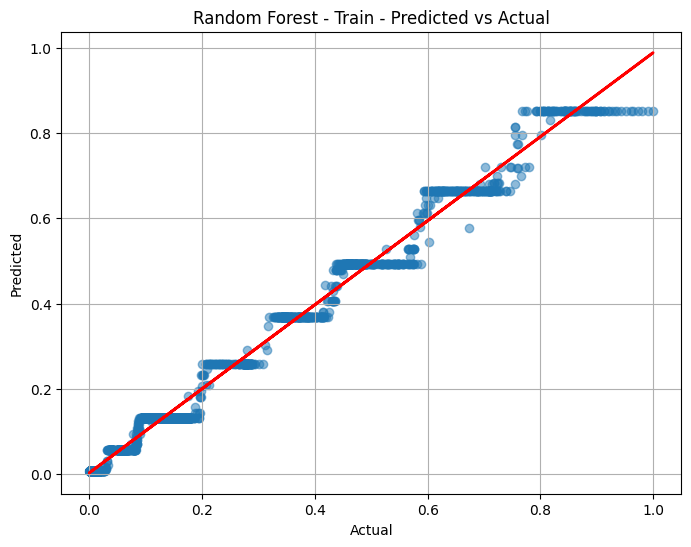

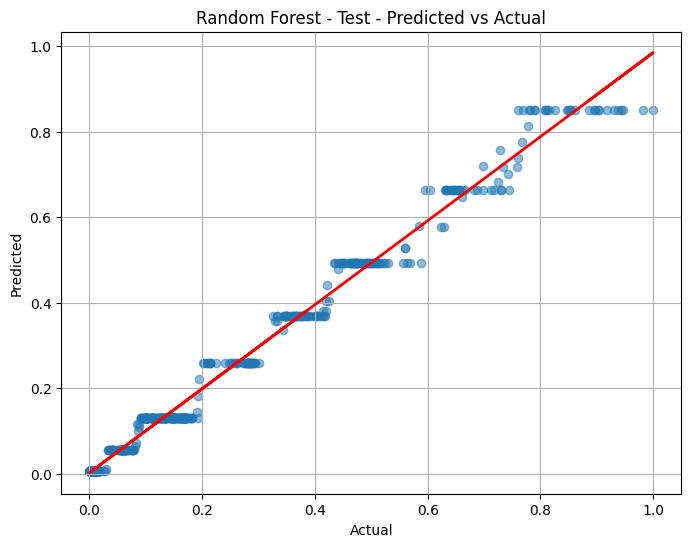

In [ ]:
# Setting seeds for reproducibility
np.random.seed(42)
random.seed(42)


# Initialising the Random Forest model with a fixed random state
rf = RandomForestRegressor(random_state=42)

# Defining hyperparameter grid for Random Forest
rf_params = {
  'n_estimators': [5, 7, 10],  # Number of trees in the forest
  'max_depth': [2, 3],  # Maximum depth of the trees
  'min_samples_split': [2, 3],  # Minimum samples required to split an internal node
  'min_samples_leaf': [5, 7],  # Minimum samples required to be at a leaf node
}

# Performing grid search optimization for the Random Forest model
best_rf, rf_train_time = PerformGridSearch(rf, rf_params, X_train_norm, y_train_norm)

# Calculating the performance metrics for training and testing data using the best_rf model
rf_train_metrics = CalculateMetrics(y_train_norm, best_rf.predict(X_train_norm))
rf_test_metrics = CalculateMetrics(y_test_norm, best_rf.predict(X_test_norm))

# Printing the results
PrintResults("Random Forest", best_rf, rf_train_metrics, rf_test_metrics, rf_train_time)

# Saving the model
dump(best_rf, 'best_rf_model.joblib')

# Visualising the PredictdVsActualPlots and Residual Plots
PredictedVsActualPlots(y_train_norm, best_rf.predict(X_train_norm), "Random Forest - Train") # Plotting the Predicted vs Actual values for the training data
PredictedVsActualPlots(y_test_norm, best_rf.predict(X_test_norm), "Random Forest - Test") # Plotting the Predicted vs Actual values for the test data

ResidualPlots(y_train_norm, best_rf.predict(X_train_norm), "Random Forest - Train") # For the training data
ResidualPlots(y_test_norm, best_rf.predict(X_test_norm), "Random Forest - Test") # For the test data

2. GBM

GBM Model:
Best Hyperparameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
__________________________________________________
Training Metrics:
Train R2: 0.8733257258364164
Train MSE: 0.007370549143077198
Train RMSE: 0.08585190238472994
Train MAE: 0.06997747769785206
Train MedianAE: 0.06161665351517372
Train ExplainedVariance: 0.8733257258364164
__________________________________________________
Testing Metrics:
Test R2: 0.8718212114085659
Test MSE: 0.0075423764870025155
Test RMSE: 0.08684685651768011
Test MAE: 0.06979464054550448
Test MedianAE: 0.06624708093758791
Test Explaine

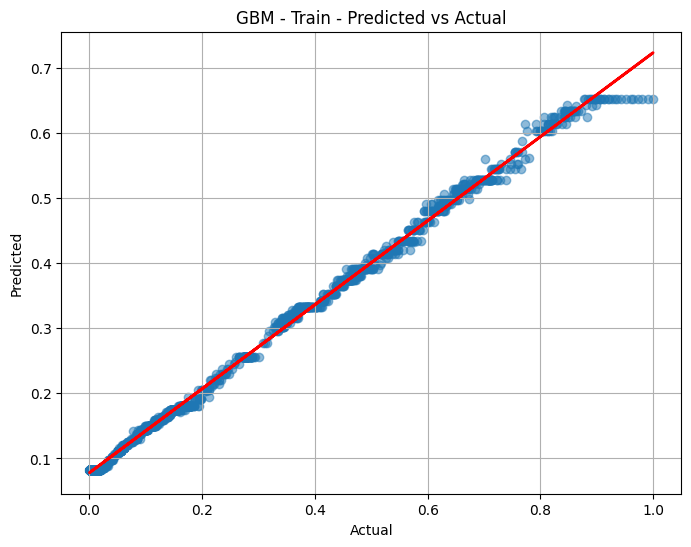

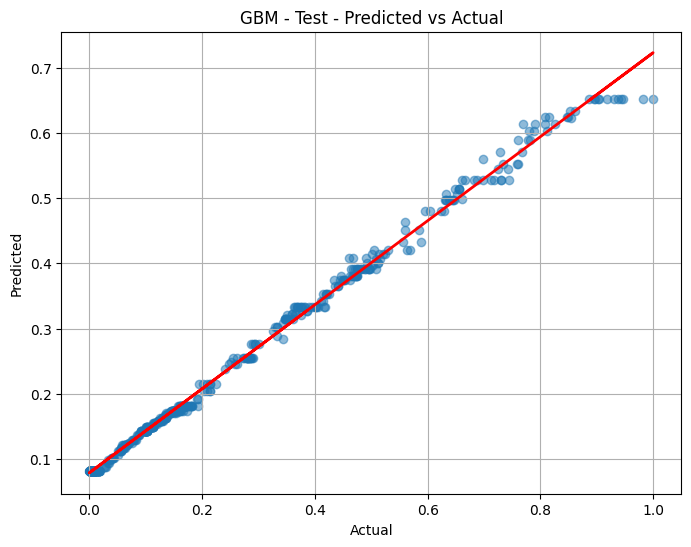

In [ ]:
# Setting fixed seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Initialising GBM model with a fixed random state for reproducibility
gbm = GradientBoostingRegressor(random_state=42)

# Hyperparameter grid for GBM model
gbm_params = {
  'n_estimators': [5, 7, 10],  # Number of boosting stages
  'max_depth': [2, 3],  # Maximum depth of the tree
  'min_samples_split': [2, 3],  # Minimum samples required to split an internal node
  'min_samples_leaf': [5, 7],  # Minimum samples required to be at a leaf node
}

# Performing grid search optimization for the GBM model
best_gbm, gbm_train_time = PerformGridSearch(gbm, gbm_params, X_train_norm, y_train_norm)

# Calculating the performance metrics for training and testing data using the best_mlp model
gbm_train_metrics = CalculateMetrics(y_train_norm, best_gbm.predict(X_train_norm))
gbm_test_metrics = CalculateMetrics(y_test_norm, best_gbm.predict(X_test_norm))

# Printing the results
PrintResults("GBM", best_gbm, gbm_train_metrics, gbm_test_metrics, gbm_train_time)

# Saving the model
dump(best_gbm, 'best_gbm_model.joblib')

# Visualising the PredictdVsActualPlots and Residual Plots
PredictedVsActualPlots(y_train_norm, best_gbm.predict(X_train_norm), "GBM - Train") # For the training data
PredictedVsActualPlots(y_test_norm, best_gbm.predict(X_test_norm), "GBM - Test") # For the test data

ResidualPlots(y_train_norm, best_gbm.predict(X_train_norm), "GBM - Train") # For training data
ResidualPlots(y_test_norm, best_gbm.predict(X_test_norm), "GBM - Test") # For the test data

**Model Comparison**

In [ ]:
# Initialising an empty list to hold the dictionaries
model_results = []

# Listing the models alongside their corresponding result dictionaries
results = [
  ("MLP", {"Train": mlp_train_metrics, "Test": mlp_test_metrics}),
  ("LSTM", {"Train": lstm_train_metrics, "Test": lstm_test_metrics}),
  ("Random Forest", {"Train": rf_train_metrics, "Test": rf_test_metrics}),
  ("GBM", {"Train": gbm_train_metrics, "Test": gbm_test_metrics})
  ]
# Looping over each model and its results dictionary to populate model_results
for model_name, results_dict in results:
  temp_dict = {'Model': model_name}
  for subset in ['Train', 'Test']:
    for metric in ['R2', 'MSE', 'RMSE', 'MAE', 'MedianAE', 'ExplainedVariance']:
      if metric in results_dict.get(subset, {}):
        key = f"{subset} {metric}"
        temp_dict[key] = results_dict.get(subset, {}).get(metric, None)
  model_results.append(temp_dict)

# Converting list of dictionaries to DataFrame
results = pd.DataFrame(model_results)

# Transposing the DataFrame
results= results.set_index('Model').transpose()
print(results.to_markdown()) # Printing the table

|                         |        MLP |       LSTM |   Random Forest |        GBM |
|:------------------------|-----------:|-----------:|----------------:|-----------:|
| Train R2                | 0.882145   | 0.817283   |     0.988856    | 0.873326   |
| Train MSE               | 0.00685742 | 0.0106314  |     0.000648398 | 0.00737055 |
| Train RMSE              | 0.0828095  | 0.103109   |     0.0254637   | 0.0858519  |
| Train MAE               | 0.0688366  | 0.0774651  |     0.0187554   | 0.0699775  |
| Train MedianAE          | 0.0631946  | 0.0618665  |     0.0144141   | 0.0616167  |
| Train ExplainedVariance | 0.8824     | 0.821283   |     0.988856    | 0.873326   |
| Test R2                 | 0.899502   | 0.861281   |     0.988008    | 0.871821   |
| Test MSE                | 0.00591357 | 0.00816258 |     0.000705653 | 0.00754238 |
| Test RMSE               | 0.0768997  | 0.090347   |     0.0265641   | 0.0868469  |
| Test MAE                | 0.0674896  | 0.0745189  |     0.01871

**Evaluating the Performance Metrics of the Models Using Bar Charts**

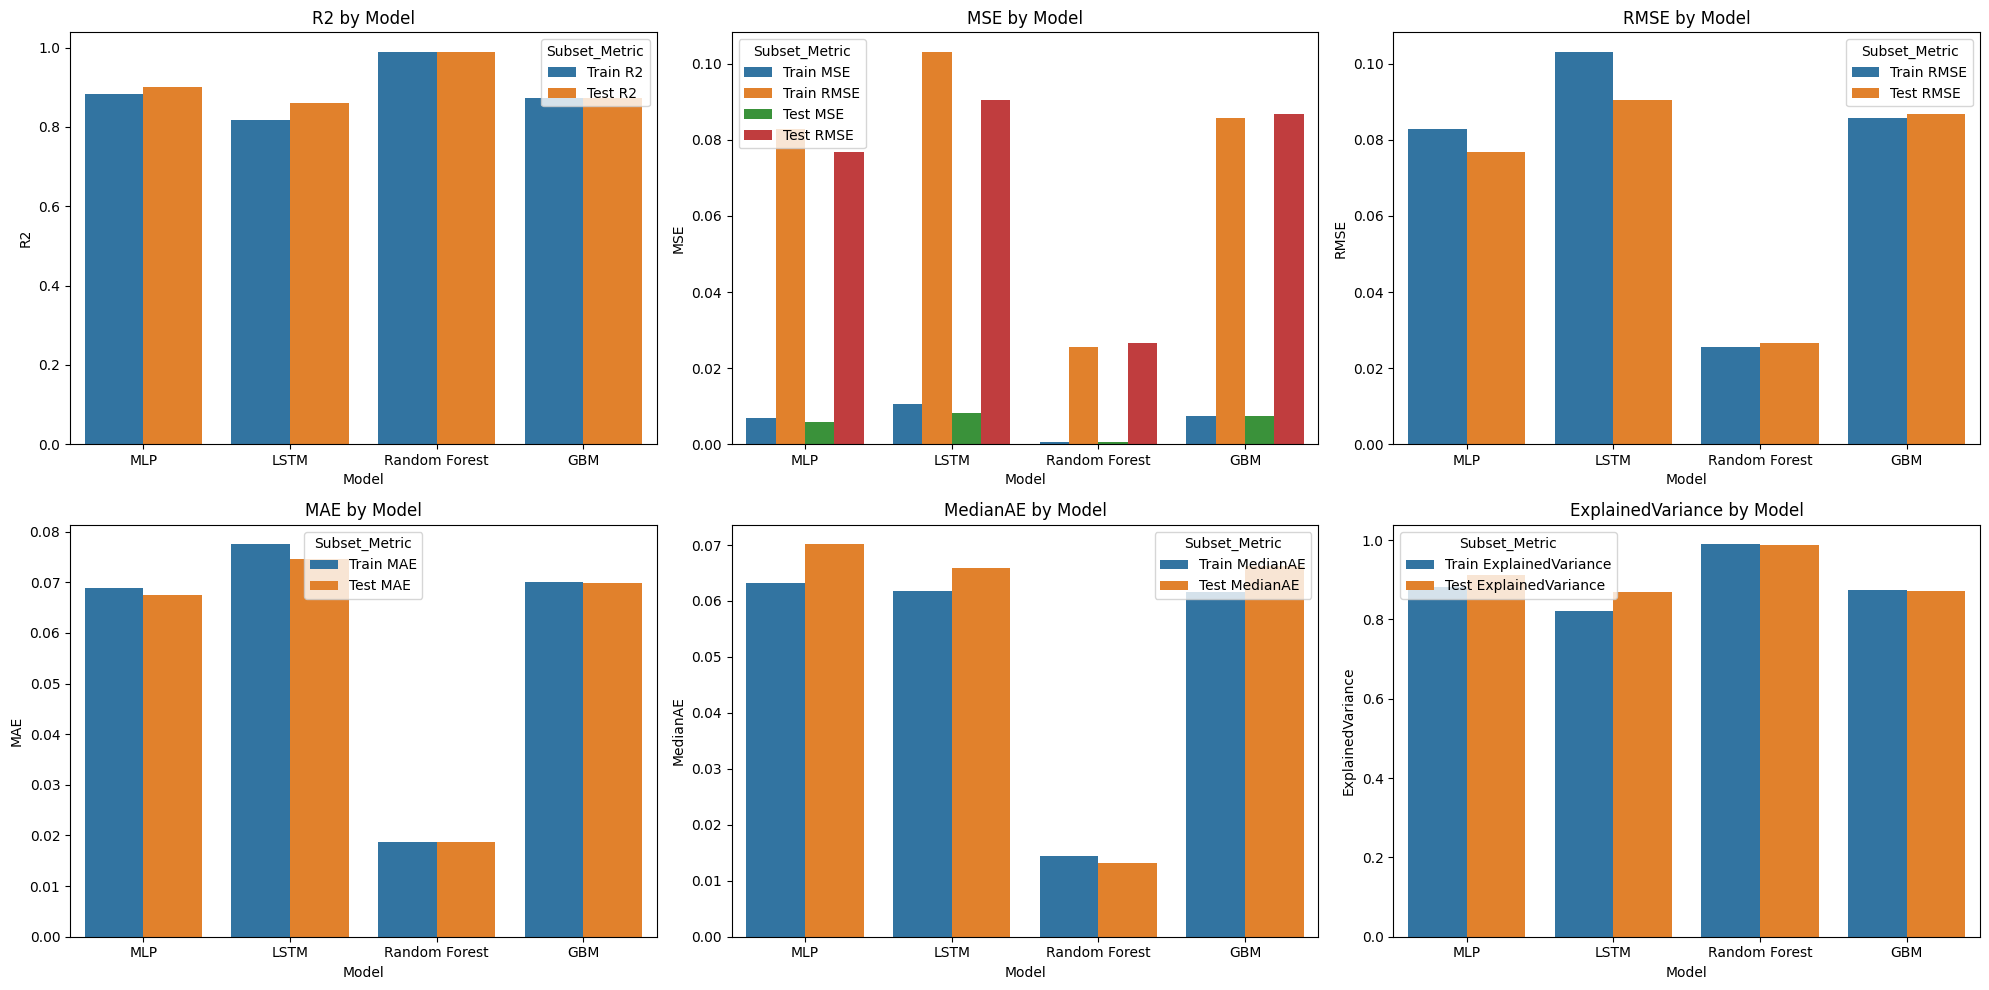

In [ ]:
# Converting list of dictionaries to DataFrame
results = pd.DataFrame(model_results)
plt.figure(figsize=(20, 10)) # Plotting

# Looping over each metric type
for metric in ['R2', 'MSE', 'RMSE', 'MAE', 'MedianAE', 'ExplainedVariance']:
  plt.subplot(2, 3, ['R2', 'MSE', 'RMSE', 'MAE', 'MedianAE', 'ExplainedVariance'].index(metric) + 1)

  # Extracting columns related to the current metric
  columns_to_plot = [col for col in results.columns if metric in col]

  # Creating DataFrame suitable for seaborn barplot
  df_to_plot = results.melt(id_vars=['Model'], value_vars=columns_to_plot, var_name='Subset_Metric', value_name=metric)

  sns.barplot(x='Model', y=metric, hue='Subset_Metric', data=df_to_plot) # Plotting
  plt.title(f'{metric} by Model')

plt.tight_layout()
plt.show()

**Selecting the Best Model each fROM the  Artificial Neural Network and Ensemble Machine Learning Models for Optimisation in order to make Further Future Predictions**

In [ ]:
# Finding the models with the highest test R2 and the lowest test MSE
best_two_models = results.sort_values(by=['Test R2', 'Test MSE', 'Test RMSE', 'Test MAE', 'Test MedianAE', 'Test ExplainedVariance'], ascending=[False, True, True, True, True, False]).iloc[:2]

# Transpose the DataFrame
best_two_models= best_two_models.set_index('Model').transpose()

# Displaying the transposed DataFrame
print("The transposed best two models are:")
print(best_two_models.to_markdown())

The transposed best two models are:
|                         |   Random Forest |        MLP |
|:------------------------|----------------:|-----------:|
| Train R2                |     0.988856    | 0.882145   |
| Train MSE               |     0.000648398 | 0.00685742 |
| Train RMSE              |     0.0254637   | 0.0828095  |
| Train MAE               |     0.0187554   | 0.0688366  |
| Train MedianAE          |     0.0144141   | 0.0631946  |
| Train ExplainedVariance |     0.988856    | 0.8824     |
| Test R2                 |     0.988008    | 0.899502   |
| Test MSE                |     0.000705653 | 0.00591357 |
| Test RMSE               |     0.0265641   | 0.0768997  |
| Test MAE                |     0.018719    | 0.0674896  |
| Test MedianAE           |     0.0131305   | 0.0700994  |
| Test ExplainedVariance  |     0.988028    | 0.911723   |


**Best Models Optimisation**

1. First Optimised Model: Optimised Random Forest Model

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Optimised Random Forest Model:
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 4, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
__________________________________________________
Training Metrics:
Train R2: 0.9998683672621311
Train MSE: 7.492948422898797e-06
Train RMSE: 0.0027373250488202526
Train MAE: 0.0014053789811509121
Train MedianAE: 0.0004965065811842681
Train ExplainedVariance: 0.9998683672636003
__________________________________________________
Testing Metrics:
Test R2: 0.9992271282904827
Test MSE: 5.078035105261567e-05
Test RMSE: 0.0071260333322694805
Test MAE: 0.0037782692005526686
Test MedianAE: 0.0012209577813524497
Te

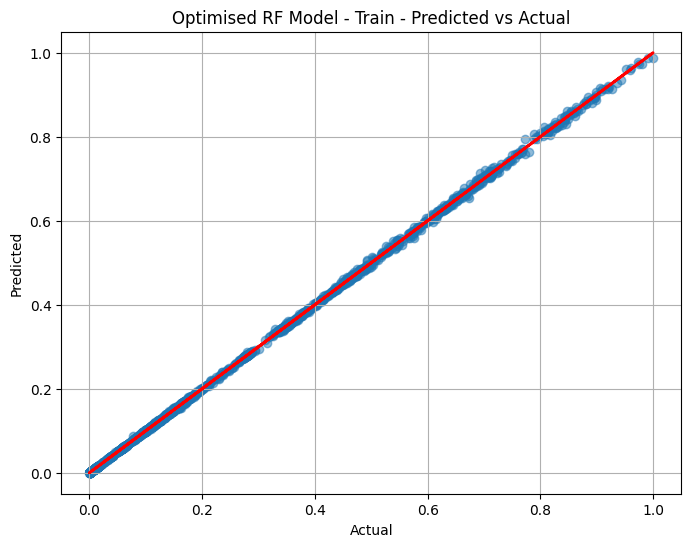

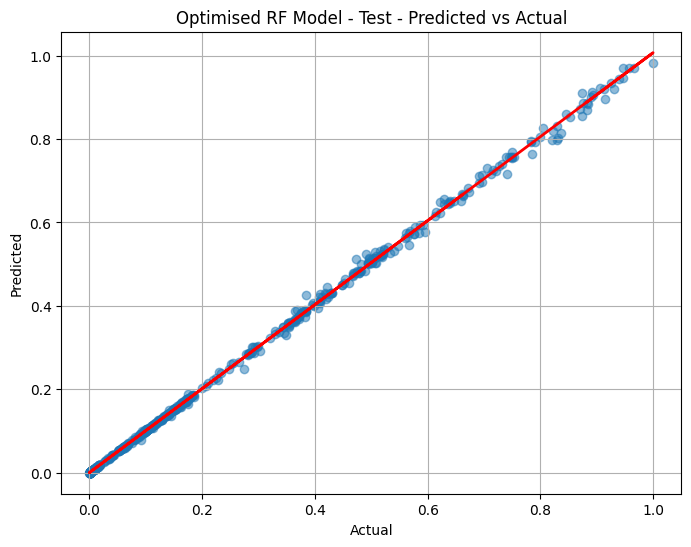

In [ ]:
# Suppressing Convergence Warning
warnings.filterwarnings("ignore", category=ConvergenceWarning) #Optional

# Setting seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Instantiating the Random Forest model
optimal_rf = RandomForestRegressor(random_state=42)

# Defining the parameter grid for Grid Search
opt_rf_params = {
  'n_estimators': [100, 150, 200],
  'max_depth': [None, 5, 10, 15],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'max_features' : [2, 3, 4],
  'bootstrap': [True, False],
}
# Recording starting time
start_time = time.time()

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Instantiating GridSearchCV
grid_search = GridSearchCV(estimator=optimal_rf, param_grid=opt_rf_params,
                           cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train_norm, y_train_norm.ravel()) # Fitting the model
best_params = grid_search.best_params_ # Getting the best hyperparameters

# Fitting the optimised RF model with the best hyperparameters
optimal_rf = RandomForestRegressor(**best_params, random_state=42)
optimal_rf.fit(X_train_norm, y_train_norm)

# Making predictions
opt_rf_train_pred = optimal_rf.predict(X_train_norm)
opt_rf_test_pred = optimal_rf.predict(X_test_norm)

# Calculating performance metrics
opt_rf_train_metrics = CalculateMetrics(y_train_norm, opt_rf_train_pred)
opt_rf_test_metrics = CalculateMetrics(y_test_norm, opt_rf_test_pred)

end_time = time.time() # Recording ending time

oprf_train_time = end_time -start_time

# Printing the results
PrintResults("Optimised Random Forest", optimal_rf, opt_rf_train_metrics, opt_rf_test_metrics, oprf_train_time)

# Saving the best RF model
dump(optimal_rf, 'optimal_rf_model.joblib')

# Visualising the PredictedVsActualPlots and Residual Plots
PredictedVsActualPlots(y_train_norm, opt_rf_train_pred, "Optimised RF Model - Train")
PredictedVsActualPlots(y_test_norm, opt_rf_test_pred, "Optimised RF Model - Test")

ResidualPlots(y_train_norm, opt_rf_train_pred, "Optimised RF Model - Train")
ResidualPlots(y_test_norm, opt_rf_test_pred, "Optimised RF Model - Test")

2. Second Optimised Model: Optimised MLP

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Optimised MLP Model:
Best Hyperparameters: {'activation': 'identity', 'alpha': 0.0001, 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 50, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
__________________________________________________
Training Metrics:
Train R2: 0.9991264088242053
Train MSE: 4.9727550523542416e-05
Train RMSE: 0.00705177640907186
Train MAE: 0.0035319131883451422
Train MedianAE: 0.0011584371543299082
Train ExplainedVariance: 0.9991266937235239
__________________________________________________
Testing Metrics:
Test R2: 0.99894575924989
Test MSE: 6.926727259559335e-05
Test RMS

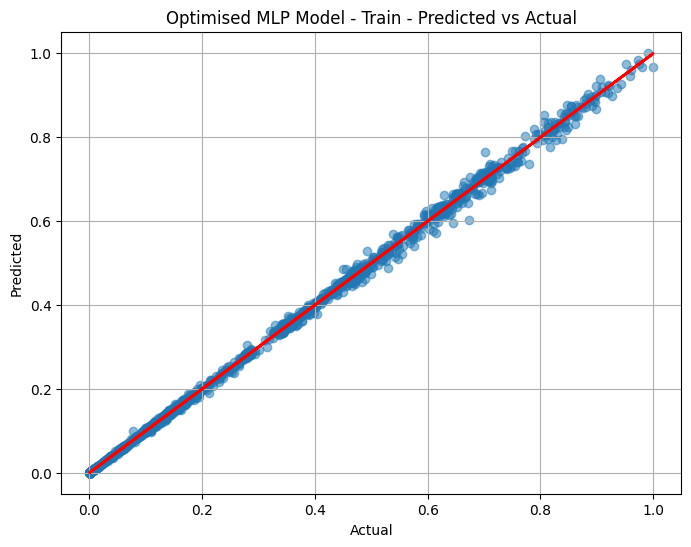

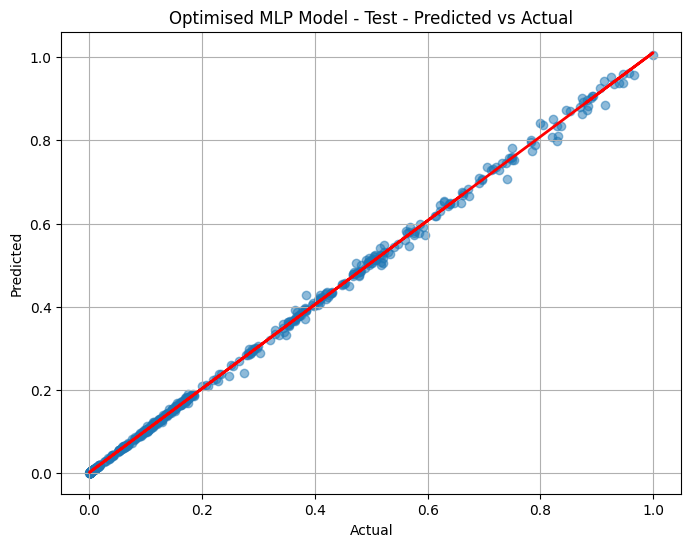

In [ ]:
# Setting seeds for reproducibility
np.random.seed(42)
random.seed(42)

y_train_norm = y_train_norm.ravel()
y_test_norm = y_test_norm.ravel()

# Instantiating the MLP model
optimal_mlp = MLPRegressor(random_state=42)

opt_mlp_params = {
  'hidden_layer_sizes': [(50,), (100,), (100, 50,),],
  'activation': ['identity', 'tanh'],
  'learning_rate_init': [0.001, 0.01, 0.1],
  'max_iter': [20, 50],
  'alpha': [0.0001, 0.001, 0.01, 0.1],
  'batch_size': [8, 16, 32],
}

start_time = time.time() # Recording starting time

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Instantiating GridSearchCV
mlp_grid_search = GridSearchCV(estimator=optimal_mlp, param_grid=opt_mlp_params,
                           cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

mlp_grid_search.fit(X_train_norm, y_train_norm)# Fitting the model
best_params = mlp_grid_search.best_params_ # Getting the best hyperparameters

# Fitting the optimised RF model with the best hyperparameters
optimal_mlp = MLPRegressor(**best_params, random_state=42)
optimal_mlp.fit(X_train_norm, y_train_norm)

# Making predictions
opt_mlp_train_pred = optimal_mlp.predict(X_train_norm)
opt_mlp_test_pred = optimal_mlp.predict(X_test_norm)

# Calculating performance metrics
opt_mlp_train_metrics = CalculateMetrics(y_train_norm, opt_mlp_train_pred)
opt_mlp_test_metrics = CalculateMetrics(y_test_norm, opt_mlp_test_pred)

end_time = time.time() # Recording ending time

opmlp_train_time = end_time -start_time

# Printing the results
PrintResults("Optimised MLP", optimal_mlp, opt_mlp_train_metrics, opt_mlp_test_metrics, opmlp_train_time)

# Saving the best RF model
dump(optimal_mlp, 'best_mlp_model.joblib')

# Visualising the PredictedVsActualPlots and Residual Plots
PredictedVsActualPlots(y_train_norm, opt_mlp_train_pred, "Optimised MLP Model - Train") # For training data
PredictedVsActualPlots(y_test_norm, opt_mlp_test_pred, "Optimised MLP Model - Test") # For test data

ResidualPlots(y_train_norm, opt_mlp_train_pred, "Optimised MLP Model - Train") # For training data
ResidualPlots(y_test_norm, opt_mlp_test_pred, "Optimised MLP Model - Test") # For test data

**Comparison of the Action Normalised Data to the Predicted Normalised Data**

In [ ]:
# Extracting the 'Date' column and keeping it aside
dates = bitcoin.index

# Splitting the data in order to get the dates info
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=42)


def CompareNormValues(X, y, dates, y_norm, pred, data_type):
  """
  This function will compare the normalized values of the actual and predicted outcomes for the train or test data).

  Parameters:
    X (array-like): The features.
    y (array-like): The actual labels.
    dates (array-like): The dates corresponding to the data points.
    y_norm (array-like): The normalized actual labels.
    pred (array-like): The normalized predicted labels.
    data_type (str): Specifies the type of data ('train' or 'test').

 Returns:
    comparison (DataFrame): A DataFrame containing the dates and corresponding actual and predicted normalized values, sorted by date.
  """

  # Reshaping the data to ensure it is a 1D array
  y_norm = y_norm.reshape(-1)
  pred = pred.reshape(-1)

  # Choosing the appropriate date array based on the data_type
  if data_type == "train":
    current_dates = dates_train # Using the training dates if data_type is 'train'
  elif data_type == "test":
    current_dates = dates_test # Using the test dates if data_type is 'test'
  else:
    raise ValueError("data_type must be 'train' or 'test'") # Raising an error if an unsupported data_type is provided


  # Converting the normalized target and predicted arrays to DataFrames
  actual_prices = pd.DataFrame({
    'Date': current_dates,
    f'Actual_Normalised_{data_type.capitalize()}': y_norm
  })
  predicted_prices = pd.DataFrame({
    'Date': current_dates,
    f'Predicted_Normalised_{data_type.capitalize()}': pred
  })

  # Merging based on 'Date' and sort by date
  comparison = pd.merge(actual_prices, predicted_prices, on='Date').sort_values(by='Date')
  return comparison

**a. Using the Optimised Random Forest Model**

In [ ]:
# For train comparison
comparison_train = CompareNormValues(X, y, dates, y_train_norm, opt_rf_train_pred, "train")
print(f'Optimial Random Forest Model: Table Comparing Actual to Predicted Normalised Bitcoin Prices-Train Data\n')
print(comparison_train)
line = '_'
print(line * 100)

# For test comparison
comparison_test = CompareNormValues(X, y, dates, y_test_norm, opt_rf_test_pred, "test")
print(f'Optimial Random Forest Model: Table Comparing Actual to Predicted Normalised Bitcoin Prices- Test Data\n')
print(comparison_test)

Optimial Random Forest Model: Table Comparing Actual to Predicted Normalised Bitcoin Prices-Train Data

           Date  Actual_Normalised_Train  Predicted_Normalised_Train
2321 2015-01-02                 0.001783                    0.001787
1117 2015-01-03                 0.001338                    0.001465
1657 2015-01-04                 0.001126                    0.001195
2113 2015-01-05                 0.001267                    0.001226
1661 2015-01-06                 0.001452                    0.001371
...         ...                      ...                         ...
936  2023-08-24                 0.415763                    0.414555
2165 2023-08-27                 0.413628                    0.414067
1073 2023-08-29                 0.414201                    0.414301
877  2023-08-30                 0.439201                    0.437495
230  2023-08-31                 0.429757                    0.430153

[2532 rows x 3 columns]
___________________________________________

**b. Using the Optimised MLP Model**

In [ ]:
# For train comparison
mlp_comparison_train = CompareNormValues(X, y, dates, y_train_norm, opt_mlp_train_pred, "train")
print(f'Optimial MLP Model: Table Comparing Actual to Predicted Normalised Bitcoin Prices-Train Data\n')
print(mlp_comparison_train)
print(line * 100)

# For test comparison
mlp_comparison_test = CompareNormValues(X, y, dates, y_test_norm, opt_mlp_test_pred, "test")
print(f'Optimial MLP Model: Table Comparing Actual to Predicted Normalised Bitcoin Prices- Test Data\n')
print(mlp_comparison_test)

Optimial MLP Model: Table Comparing Actual to Predicted Normalised Bitcoin Prices-Train Data

           Date  Actual_Normalised_Train  Predicted_Normalised_Train
2321 2015-01-02                 0.001783                    0.001971
1117 2015-01-03                 0.001338                    0.001798
1657 2015-01-04                 0.001126                    0.001448
2113 2015-01-05                 0.001267                    0.001429
1661 2015-01-06                 0.001452                    0.001569
...         ...                      ...                         ...
936  2023-08-24                 0.415763                    0.414578
2165 2023-08-27                 0.413628                    0.415594
1073 2023-08-29                 0.414201                    0.415342
877  2023-08-30                 0.439201                    0.425409
230  2023-08-31                 0.429757                    0.434434

[2532 rows x 3 columns]
_____________________________________________________

**Some Visuals Showing the Actual/Original Bitcoin Data to the Predicted Data through Denormalisation Before Future Predictive Analysis**

In [ ]:
# Setting min-max range
y_min = y.min()
y_range = y.max() - y.min()

# Denormalizing the training and test data
y_train_denorm = y_train_norm * y_range + y_min
y_test_denorm = y_test_norm * y_range + y_min

# For the optimised Random Forest Model
opt_rf_train_pred_denorm = opt_rf_train_pred * y_range + y_min
opt_rf_test_pred_denorm = opt_rf_test_pred * y_range + y_min

# For the optimised MLP Model
opt_mlp_train_pred_denorm = opt_mlp_train_pred * y_range + y_min
opt_mlp_test_pred_denorm = opt_mlp_test_pred * y_range + y_min

1. Line Charts/Time Series Plots

In [ ]:
def LineChart(dates, actual, predicted, title):
  """
  The function will plot line charts/plots for the two optimised model showing the predicted and actual prices of the historical data.
  """
  # Converting the denormalized arrays to DataFrames
  actual = pd.DataFrame({
    'Date': dates,
    'Actual_Price': actual.flatten()
  })
  predicted = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted.flatten()
  })

  # Merging based on 'Date' and sorting by date
  compare = pd.merge(actual, predicted, on='Date').sort_values(by='Date')

  # Initializing a Plotly Figure object
  fig = go.Figure()

  # Adding a trace for actual prices
  fig.add_trace(go.Scatter(x=compare['Date'],
                            y=compare['Actual_Price'],
                            mode='lines',
                            name='Actual Prices'))

  # Adding a trace for predicted prices
  fig.add_trace(go.Scatter(x=compare['Date'],
                            y=compare['Predicted_Price'],
                            mode='lines',
                            name='Predicted Prices'))

  # Updating the layout of the figure, including titles and dimensions
  fig.update_layout(title=title,
                    xaxis_title='Date',
                    yaxis_title='Price',
                    height=500,
                    width=900)

  # Displaying the figure
  fig.show()

a. The Optimised Random Forest Model's Line Chart for the Historical/Actual Data vs Predicted Data

In [ ]:
# For the train data
LineChart(dates_train, y_train_denorm, opt_rf_train_pred_denorm, 'Optimised Random Forest Model Comparison of Actual and Predicted Prices (Train Data)')

# For the test data
LineChart(dates_test, y_test_denorm, opt_rf_test_pred_denorm, 'Optimised Random Forest Model Comparison of Actual and Predicted Prices (Test Data)')

**b. the Optimised MLP Model's Line Chart for the Historical/Actual Data vs Predicted Data**

In [ ]:
# For the train data
LineChart(dates_train, y_train_denorm, opt_mlp_train_pred_denorm, 'Optimised MLP Model: Comparison of Actual and Predicted Prices (Train Data)')

# For the test data
LineChart(dates_test, y_test_denorm, opt_mlp_test_pred_denorm, 'Optimised MLP Model: Comparison of Actual and Predicted Prices (Test Data)')

**Area Charts**

In [ ]:
def AreaChart(dates, actual, predicted, title):
  """
  The function will plot area charts for the two optimised model showing the predicted and actual prices of the historical data.
  """
  # Converting the denormalized arrays to DataFrames
  actual = pd.DataFrame({
    'Date': dates,
    'Actual_Price': actual.flatten()
  })
  predicted = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted.flatten()
  })

  # Merging based on 'Date' and sorting by date
  compare = pd.merge(actual, predicted, on='Date').sort_values(by='Date')

  # Initializing a Plotly Figure object
  fig = go.Figure()

  # Adding a trace for actual prices
  fig.add_trace(go.Scatter(x=compare['Date'],
                            y=compare['Actual_Price'],
                            mode='lines',
                            name='Actual Prices',
                            fill='tonexty'))

  # Adding a trace for predicted prices
  fig.add_trace(go.Scatter(x=compare['Date'],
                            y=compare['Predicted_Price'],
                            mode='lines',
                            name='Predicted Prices',
                            fill='tonexty'))

  # Updating the layout of the figure, including titles and dimensions
  fig.update_layout(title=title,
                    xaxis_title='Date',
                    yaxis_title='Price',
                    height=500,
                    width=900)

  # Displaying the figure
  fig.show()

a. The Optimised Random Forest Model's Area Chart for the Historical/Actual Data vs Predicted Data

In [ ]:
# For the train data
AreaChart(dates_train, y_train_denorm, opt_rf_train_pred_denorm, 'Optimised Random Forest Model: Comparison of Actual and Predicted Prices (Train Data)')

# For the test data
AreaChart(dates_test, y_test_denorm, opt_rf_test_pred_denorm, 'Optimised Random Forest Model: Comparison of Actual and Predicted Prices (Test Data)')

a. The Optimised MLP Model's Area Chart for the Historical/Actual Data vs Predicted Data

In [ ]:
# For the train data
AreaChart(dates_train, y_train_denorm, opt_mlp_train_pred_denorm, 'Optimised MLP Model: Comparison of Actual and Predicted Prices (Train Data)')

# For the test data
AreaChart(dates_test, y_test_denorm, opt_mlp_test_pred_denorm, 'Optimised MLP Model: Comparison of Actual and Predicted Prices (Test Data)')

# MAKING FUTURE PREDICTIONS




**1. Function to Predict Future Bitcoin Prices for the Next 30 Days in Normalised Form**

In [ ]:
# Loading the bitcoin data again
X = bitcoin.drop("Close", axis=1)  # All features except 'Close' (target variable)
y = bitcoin["Close"]  # Target variable 'Close'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation for scalers x and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Assigning scaler_X to X_train and X_test, scaler_y to y_train and y_test
X_train_norm = scaler_X.fit_transform(X_train)
X_test_norm = scaler_X.transform(X_test)
y_train_norm = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_norm = scaler_y.transform(y_test.values.reshape(-1, 1))


def PredictionTable(model, initial_data, column_names, predict_days=30):
  """
  The function will predict future prices of the time-series Bitcoin data using the optimised models

  Parameters:
    model (Model Object): Trained Optimised models for prediction.
    initial_data (array-like): The most recent sequence of data to use as the basis for making future predictions.
    column_names (list): List of column names for the features used for prediction.
    predict_days (int): Number of days into the future to predict. Default is 30.

  Returns:
    predicted_sequences (DataFrame): DataFrame containing predicted values for the specified number of future days.
  """
  # Converting to DataFrame to maintain feature names
  btc_norm = pd.DataFrame(initial_data, columns=column_names)

  # Starting with the most recent data point for prediction
  btc_norm = btc_norm.iloc[-1:].copy()

  # Initialising an empty DataFrame to store the predicted sequences for each future day
  predicted_sequences = pd.DataFrame(columns=column_names)

  # Looping to predict the next `predict_days` number of days
  for day in range(predict_days):
    # Predicting the next day using the model for the 'Close' column
    prediction = model.predict(btc_norm)

    # Creating a copy of current normalized data to add to the sequence
    current_data = btc_norm.copy()
    current_data['Close'] = prediction[0]

    # Storing the sequence in the DataFrame
    predicted_sequences = pd.concat([predicted_sequences, current_data], ignore_index=True)

    # Rolling the existing data to prepare for the next prediction
    new_row = np.roll(btc_norm.values, shift=-1, axis=1)
    new_row[0][-1] = prediction[0]
    btc_norm = pd.DataFrame(new_row, columns=column_names)

  return predicted_sequences


a. Making Predictions for the Next 90 Days in Normalised Form (For the Optimised Random Forest Model)

In [ ]:
# Column names and prediction days
column_names = ['Open', 'High', 'Low', 'Volume']
predict_days = 30

# Generating prediction table
opt_rf_pred_table = PredictionTable(optimal_rf, X_test_norm, column_names, predict_days)

# Calculating the start date for prediction as the day following today's date
start_predict_date = pd.Timestamp.today() + pd.Timedelta(days=1)

# Generating a date range starting from `start_predict_date` for the next `predict_days`
predict_dates = pd.date_range(start=start_predict_date, periods=predict_days)

# Attaching the generated date range to the prediction table as a new 'Date' column
opt_rf_pred_table['Date'] = predict_dates
opt_rf_pred_table.set_index('Date', inplace=True)

# Displaying the prediction table with 'Date' as the index
opt_rf_pred_table

Open      High       Low    Volume     Close
Date                                                                        
2023-09-02 14:30:19.190584  0.865002  0.846355  0.857762  0.096619  0.850695
2023-09-03 14:30:19.190584  0.846355  0.857762  0.096619  0.850695  0.288587
2023-09-04 14:30:19.190584  0.857762  0.096619  0.850695  0.288587  0.501096
2023-09-05 14:30:19.190584  0.096619  0.850695  0.288587  0.501096  0.357895
2023-09-06 14:30:19.190584  0.850695  0.288587  0.501096  0.357895  0.383125
2023-09-07 14:30:19.190584  0.288587  0.501096  0.357895  0.383125  0.453003
2023-09-08 14:30:19.190584  0.501096  0.357895  0.383125  0.453003  0.373485
2023-09-09 14:30:19.190584  0.357895  0.383125  0.453003  0.373485  0.411264
2023-09-10 14:30:19.190584  0.383125  0.453003  0.373485  0.411264  0.429777
2023-09-11 14:30:19.190584  0.453003  0.373485  0.411264  0.429777  0.392697
2023-09-12 14:30:19.190584  0.373485  0.411264  0.429777  0.392697  0.413628
2023-09-13 14:30:19.190584  0.411264  0.429777  0.392697  0.413628  0.417522
2023-09-14 14:30:19.190584  0.429777  0.392697  0.413628  0.417522  0.404212
2023-09-15 14:30:19.190584  0.392697  0.413628  0.417522  0.404212  0.411279
2023-09-16 14:30:19.190584  0.413628  0.417522  0.404212  0.411279  0.417420
2023-09-17 14:30:19.190584  0.417522  0.404212  0.411279  0.417420  0.408920
2023-09-18 14:30:19.190584  0.404212  0.411279  0.417420  0.408920  0.412040
2023-09-19 14:30:19.190584  0.411279  0.417420  0.408920  0.412040  0.419349
2023-09-20 14:30:19.190584  0.417420  0.408920  0.412040  0.419349  0.409522
2023-09-21 14:30:19.190584  0.408920  0.412040  0.419349  0.409522  0.414831
2023-09-22 14:30:19.190584  0.412040  0.419349  0.409522  0.414831  0.420375
2023-09-23 14:30:19.190584  0.419349  0.409522  0.414831  0.420375  0.410087
2023-09-24 14:30:19.190584  0.409522  0.414831  0.420375  0.410087  0.417644
2023-09-25 14:30:19.190584  0.414831  0.420375  0.410087  0.417644  0.420826
2023-09-26 14:30:19.190584  0.420375  0.410087  0.417644  0.420826  0.411195
2023-09-27 14:30:19.190584  0.410087  0.417644  0.420826  0.411195  0.422799
2023-09-28 14:30:19.190584  0.417644  0.420826  0.411195  0.422799  0.421373
2023-09-29 14:30:19.190584  0.420826  0.411195  0.422799  0.421373  0.415608
2023-09-30 14:30:19.190584  0.411195  0.422799  0.421373  0.415608  0.427252
2023-10-01 14:30:19.190584  0.422799  0.421373  0.415608  0.427252  0.421508

b. Making Predictions for the Next 30 Days in Normalised Form (For the Optimised MLP Model)

In [ ]:
# Generate prediction table
opt_mlp_pred_table = PredictionTable(optimal_mlp, X_test_norm, column_names, predict_days)

# Calculating the start date for prediction as the day following today's date
start_predict_date = pd.Timestamp.today() + pd.Timedelta(days=1)

# Generating a date range starting from `start_predict_date` for the next `predict_days`
predict_dates = pd.date_range(start=start_predict_date, periods=predict_days)

# Attaching the generated date range to the prediction table as a new 'Date' column
opt_mlp_pred_table['Date'] = predict_dates
opt_mlp_pred_table.set_index('Date', inplace=True)

# Displaying the prediction table with 'Date' as the index
opt_mlp_pred_table

Open      High       Low    Volume     Close
Date                                                                        
2023-09-02 14:30:19.292693  0.865002  0.846355  0.857762  0.096619  0.857163
2023-09-03 14:30:19.292693  0.846355  0.857762  0.096619  0.857163  0.487414
2023-09-04 14:30:19.292693  0.857762  0.096619  0.857163  0.487414  0.611468
2023-09-05 14:30:19.292693  0.096619  0.857163  0.487414  0.611468  0.551485
2023-09-06 14:30:19.292693  0.857163  0.487414  0.611468  0.551485  0.619347
2023-09-07 14:30:19.292693  0.487414  0.611468  0.551485  0.619347  0.568492
2023-09-08 14:30:19.292693  0.611468  0.551485  0.619347  0.568492  0.602922
2023-09-09 14:30:19.292693  0.551485  0.619347  0.568492  0.602922  0.590294
2023-09-10 14:30:19.292693  0.619347  0.568492  0.602922  0.590294  0.601979
2023-09-11 14:30:19.292693  0.568492  0.602922  0.590294  0.601979  0.598593
2023-09-12 14:30:19.292693  0.602922  0.590294  0.601979  0.598593  0.606046
2023-09-13 14:30:19.292693  0.590294  0.601979  0.598593  0.606046  0.606175
2023-09-14 14:30:19.292693  0.601979  0.598593  0.606046  0.606175  0.610757
2023-09-15 14:30:19.292693  0.598593  0.606046  0.606175  0.610757  0.612773
2023-09-16 14:30:19.292693  0.606046  0.606175  0.610757  0.612773  0.616392
2023-09-17 14:30:19.292693  0.606175  0.610757  0.612773  0.616392  0.618982
2023-09-18 14:30:19.292693  0.610757  0.612773  0.616392  0.618982  0.622265
2023-09-19 14:30:19.292693  0.612773  0.616392  0.618982  0.622265  0.625139
2023-09-20 14:30:19.292693  0.616392  0.618982  0.622265  0.625139  0.628285
2023-09-21 14:30:19.292693  0.618982  0.622265  0.625139  0.628285  0.631285
2023-09-22 14:30:19.292693  0.622265  0.625139  0.628285  0.631285  0.634401
2023-09-23 14:30:19.292693  0.625139  0.628285  0.631285  0.634401  0.637467
2023-09-24 14:30:19.292693  0.628285  0.631285  0.634401  0.637467  0.640587
2023-09-25 14:30:19.292693  0.631285  0.634401  0.637467  0.640587  0.643697
2023-09-26 14:30:19.292693  0.634401  0.637467  0.640587  0.643697  0.646837
2023-09-27 14:30:19.292693  0.637467  0.640587  0.643697  0.646837  0.649981
2023-09-28 14:30:19.292693  0.640587  0.643697  0.646837  0.649981  0.653147
2023-09-29 14:30:19.292693  0.643697  0.646837  0.649981  0.653147  0.656323
2023-09-30 14:30:19.292693  0.646837  0.649981  0.653147  0.656323  0.659516
2023-10-01 14:30:19.292693  0.649981  0.653147  0.656323  0.659516  0.662723

**2. Function to Predict Future Bitcoin Prices for the Next 30 Days Through Denormalisation**

In [ ]:
def ExtendDates(start_date, end_date, num_days=30):
  """
  This function will extend the date range by num_days from the end_date of the raw/original data.
  """
  original_dates = pd.date_range(start=start_date, end=end_date)
  extended_dates = [original_dates[-1] + pd.DateOffset(days=i) for i in range(1, num_days + 1)]
  extended_dates_str = [date.strftime("%Y-%m-%d") for date in extended_dates]
  return extended_dates_str

start_date = "2015-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")
predict_dates = ExtendDates(start_date, end_date)

**1. Future Predictions for the Next 30 Days Using Random Forest**

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Selecting columns
original_features = X_test.columns
to_denormalize = opt_rf_pred_table[original_features] # Filtering relevant columns in the table

# Transforming the filtered table
denormalized_features = scaler_X_test.inverse_transform(to_denormalize)

# Generating new table from transformed data
denorm_rf_pred_table = pd.DataFrame(denormalized_features, columns=original_features, index=opt_rf_pred_table.index)

# Applying transformation to a specific column in table
denormalized_close = scaler_y_test.inverse_transform(opt_rf_pred_table[['Close']])
denorm_rf_pred_table['Close'] = denormalized_close

# Ensuring row count matches with date list
if len(predict_dates) != len(denorm_rf_pred_table):
  print("Row count mismatch: Verify that the number of dates aligns with the number of rows in the table.")
else:
  denorm_rf_pred_table['Date'] = predict_dates
  denorm_rf_pred_table.set_index('Date', inplace=True)

# Outputing the transformed table
width = 100

# Center-align the title
title = "FUTURE PREDICTIONS FOR THE NEXT 30 DAYS (RANDOM FOREST MODEL)"
centered_title = title.center(width)

# Printing the predicted future prices by the optimised RF model in their (denormalized) real-form
print(centered_title)
denorm_rf_pred_table

                   FUTURE PREDICTIONS FOR THE NEXT 30 DAYS (RANDOM FOREST MODEL)                    


Open      High       Low          Volume     Close
Date                                                              
2023-09-02 41384.968 40977.619 40493.243  6820001286.014 40902.641
2023-09-03 40495.339 41527.950  4664.196 60007542440.356 13964.745
2023-09-04 41039.550  4805.837 40160.577 20360185114.369 24148.809
2023-09-05  4725.773 41186.992 13700.665 35349152472.241 17286.196
2023-09-06 40702.384 14067.546 23704.024 25248716448.092 18495.300
2023-09-07 13884.496 24320.247 16963.180 27028282535.912 21844.041
2023-09-08 24023.190 17411.382 18150.829 31956980198.075 18033.293
2023-09-09 17191.150 18628.634 21440.151 26348298274.021 19843.761
2023-09-10 18394.867 21999.945 17697.021 29012955980.166 20730.975
2023-09-11 21728.689 18163.514 19475.364 30318762507.970 18954.013
2023-09-12 17934.918 19986.184 20346.835 27703419696.009 19957.058
2023-09-13 19737.321 20879.377 18601.404 29179707379.538 20143.672
2023-09-14 20620.582 19090.439 19586.651 29454366515.454 19505.816
2023-09-15 18851.537 20100.244 19769.953 28515566242.294 19844.493
2023-09-16 19850.113 20288.116 19143.415 29014033868.076 20138.818
2023-09-17 20035.895 19645.961 19476.083 29447222297.399 19731.468
2023-09-18 19400.881 19986.921 19765.185 28847682066.893 19880.978
2023-09-19 19738.050 20283.229 19365.063 29067733008.749 20231.249
2023-09-20 20031.063 19873.134 19511.921 29583264039.010 19760.293
2023-09-21 19625.528 20023.652 19855.977 28890107327.369 20014.740
2023-09-22 19774.372 20376.284 19393.377 29264604650.763 20280.423
2023-09-23 20123.083 19902.153 19643.309 29655637814.598 19787.363
2023-09-24 19654.224 20158.316 19904.278 28929949703.338 20149.538
2023-09-25 19907.538 20425.789 19419.967 29463001045.485 20302.013
2023-09-26 20172.037 19929.406 19775.716 29687415018.477 19840.477
2023-09-27 19681.174 20294.022 19925.485 29008122856.485 20396.593
2023-09-28 20041.736 20447.525 19472.138 29826618445.517 20328.234
2023-09-29 20193.532 19982.878 20018.387 29726006238.466 20051.971
2023-09-30 19734.051 20542.742 19951.240 29319401545.299 20609.998
2023-10-01 20287.690 20473.922 19679.880 30140708178.563 20334.683

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Selecting columns
original_features = X_test.columns
to_denormalize_mlp = opt_mlp_pred_table[original_features] # Filtering relevant columns in the table

# Transforming the filtered table
denorm_mlp_features = scaler_X_test.inverse_transform(to_denormalize_mlp)

# Generating new table from transformed data
denorm_mlp_pred_table = pd.DataFrame(denorm_mlp_features, columns=original_features, index=opt_mlp_pred_table.index)

# Applying transformation to a specific column in table
denorm_mlp_close = scaler_y_test.inverse_transform(opt_mlp_pred_table[['Close']])
denorm_mlp_pred_table['Close'] = denorm_mlp_close

# Ensuring row count matches with date list
if len(predict_dates) != len(denorm_mlp_pred_table):
  print("Row count mismatch: Verify that the number of dates aligns with the number of rows in the table.")
else:
  denorm_mlp_pred_table['Date'] = predict_dates
  denorm_mlp_pred_table.set_index('Date', inplace=True)

# Outputing the transformed table
width = 100

# Center-align the title
title = "FUTURE PREDICTIONS FOR THE NEXT 30 DAYS (MLP MODEL)"
centered_title = title.center(width)

# Printing the predicted results for the optimised MLP in their denormalised (real) form
print(centered_title)
denorm_mlp_pred_table

                        FUTURE PREDICTIONS FOR THE NEXT 30 DAYS (MLP MODEL)                         


Open      High       Low          Volume     Close
Date                                                              
2023-09-02 41384.968 40977.619 40493.243  6820001286.014 41212.587
2023-09-03 40495.339 41527.950  4664.196 60463723335.344 23493.104
2023-09-04 41039.550  4805.837 40465.024 34384081185.842 29438.143
2023-09-05  4725.773 41499.027 23059.953 43134025524.234 26563.603
2023-09-06 41010.949 23660.122 28899.504 38903260352.513 29815.748
2023-09-07 23370.406 29645.228 26075.970 43689786550.744 27378.625
2023-09-08 29288.960 26751.315 29270.409 40102814892.018 29028.611
2023-09-09 26427.226 30025.378 26876.530 42531274091.690 28423.418
2023-09-10 29664.883 27571.830 28497.239 41640546756.007 28983.396
2023-09-11 27238.617 29232.936 27902.784 42464726257.400 28821.146
2023-09-12 28881.253 28623.664 28452.826 42225925687.370 29178.322
2023-09-13 28278.755 29187.416 28293.455 42751619671.521 29184.514
2023-09-14 28836.239 29024.073 28644.294 42760732870.832 29404.080
2023-09-15 28674.712 29383.656 28650.376 43083891389.919 29500.684
2023-09-16 29030.297 29389.890 28866.046 43226074431.962 29674.114
2023-09-17 29036.461 29610.936 28960.936 43481329273.570 29798.239
2023-09-18 29255.049 29708.191 29131.288 43664016385.639 29955.581
2023-09-19 29351.223 29882.790 29253.210 43895594442.109 30093.310
2023-09-20 29523.880 30007.751 29407.761 44098303543.222 30244.076
2023-09-21 29647.451 30166.154 29543.046 44320202038.586 30387.852
2023-09-22 29804.093 30304.810 29691.137 44531812507.332 30537.188
2023-09-23 29941.208 30456.593 29832.361 44751606525.390 30684.094
2023-09-24 30091.302 30601.338 29979.048 44967824293.703 30833.643
2023-09-25 30234.438 30751.680 30123.348 45187930497.934 30982.667
2023-09-26 30383.109 30899.577 30270.242 45407265013.982 31133.141
2023-09-27 30529.361 31050.133 30416.622 45628734540.999 31283.835
2023-09-28 30678.243 31200.162 30564.427 45850526463.252 31435.530
2023-09-29 30826.603 31351.650 30712.447 46073792084.453 31587.738
2023-09-30 30976.407 31503.360 30861.450 46297813039.533 31740.771
2023-10-01 31126.430 31656.077 31010.958 46523047852.069 31894.439

# MORE ON VISUALISATION

**1. Line Charts to Visualise the Historical Data Alongside the Predicted Future 30 Days 'Close' Prices After Denormalisation**

In [ ]:
def PlotBitcoinData(bitcoin, predicted_tables, model_names):
    """
    Plots the historical and predicted Bitcoin data.

    Parameters:
    - bitcoin: DataFrame containing the historical Bitcoin data
    - predicted_tables: list of DataFrames containing the predicted data for different models
    - model_names: list of strings indicating the names of the models for which predictions are made
    """

    # Creating traces for the historical data
    trace_open = go.Scatter(x=bitcoin.index, y=bitcoin['Open'], mode='lines', name='Open', line=dict(color='blue'))
    trace_high = go.Scatter(x=bitcoin.index, y=bitcoin['High'], mode='lines', name='High', line=dict(color='yellow'))
    trace_low = go.Scatter(x=bitcoin.index, y=bitcoin['Low'], mode='lines', name='Low', line=dict(color='red'))
    trace_close = go.Scatter(x=bitcoin.index, y=bitcoin['Close'], mode='lines', name='Close', line=dict(color='green'))

    # Initialising traces list with historical data
    all_traces = [trace_open, trace_high, trace_low, trace_close]

    # Loop over each model's predictions and create a new plot for each
    for i, table in enumerate(predicted_tables):
      # Creating traces for the predicted 'Close' prices for each model
      trace_predicted_close = go.Scatter(x=table.index, y=table['Close'], mode='lines', name=f'Predicted Close ({model_names[i]})', line=dict(dash='dash'))
      subplot_combined = go.Figure(data=all_traces + [trace_predicted_close])  # Creating the plot

      # Setting the layout for the figure
      subplot_combined.update_layout(
      title=f'Bitcoin (BTC) Historical & Predicted Prices ({model_names[i]})',
      xaxis_title='Date(Year)',
      yaxis_title='Price (£)',
      xaxis_rangeslider_visible=True,
      height=800,
      width=1200)

      # Displaying the combined plot
      subplot_combined.show()

# Assigning predicted_tables to hold both the optimised RF and MLP predicted info
predicted_tables = [denorm_rf_pred_table, denorm_mlp_pred_table]
model_names = ['Optimised Random Forest', 'Optimised MLP']

# Calling the function
PlotBitcoinData(bitcoin, predicted_tables, model_names)

**2. Visualisng the Predicted Future Prices for the Next 30 Days Using Line Chart**

In [ ]:
def PlotPredictedFuturePrices(predicted_tables, model_names):
  """
  The function will plot the predicted Bitcoin data for the two optimised models.

  Parameters:
  - predicted_tables: list of DataFrames containing the predicted data for different models
  - model_names: list of strings indicating the names of the models (either optimised RF or MLP) for which predictions are made.
  """

  for i, table in enumerate(predicted_tables):
    # Creating traces for the denormalized predictions
    trace_open = go.Scatter(x=table.index, y=table['Open'], mode='lines', name=f'Predicted Open ({model_names[i]})', line=dict(color='blue'))
    trace_high = go.Scatter(x=table.index, y=table['High'], mode='lines', name=f'Predicted High ({model_names[i]})', line=dict(color='green'))
    trace_low = go.Scatter(x=table.index, y=table['Low'], mode='lines', name=f'Predicted Low ({model_names[i]})', line=dict(color='red'))
    trace_close = go.Scatter(x=table.index, y=table['Close'], mode='lines', name=f'Predicted Close ({model_names[i]})', line=dict(color='purple'))

    # Creating the subplot for denormalized prediction
    subplot_pred = go.Figure(data=[trace_open, trace_high, trace_low, trace_close])

    # Updating layout
    subplot_pred.update_layout(
      title=f'Bitcoin (BTC) Predicted Prices for the Next 30 Days ({model_names[i]})',
      xaxis_title='Date',
      yaxis_title='Predicted Price (£)',
      height=800,
      width=1200)  # Increased the width for better visibility

    subplot_pred.show()  # Displaying the plot

predicted_tables = [denorm_rf_pred_table, denorm_mlp_pred_table]
model_names = ['Optimised Random Forest', 'Optimised MLP']

PlotPredictedFuturePrices(predicted_tables, model_names)

a. Tracing the Random Forest Close Prices for the Next  Days

In [ ]:
# Creating trace for the denormalised Random Forest predictions (Close Price)
trace_rf_close = go.Scatter(x=denorm_rf_pred_table.index, y=denorm_rf_pred_table['Close'], mode='lines', name='Predicted Close (RF)', line=dict(color='purple'))

# Creating the figure for denormalised Random Forest prediction
fig1 = go.Figure(data=[trace_rf_close])
fig1.update_layout(
  title='Bitcoin (BTC) Predicted Close Prices for the Next 30 Days (Random Forest)',
  xaxis_title='Date',
  yaxis_title='Predicted Close Price (£)',
  height=500,
  width=900)

fig1.show()  # Displaying the plot for Random Forest

b. Tracing the MLP Close Prices for the Next 30 Days

In [ ]:
# Creating trace for the denormalised MLP predictions (Close Price)
trace_mlp_close = go.Scatter(x=denorm_mlp_pred_table.index, y=denorm_mlp_pred_table['Close'], mode='lines', name='Predicted Close (MLP)', line=dict(color='purple'))

# Creating the figure for denormalised MLP prediction
fig2 = go.Figure(data=[trace_mlp_close])
fig2.update_layout(
  title='Bitcoin (BTC) Predicted Close Prices for the Next 30 Days (MLP)',
  xaxis_title='Date',
  yaxis_title='Predicted Close Price (£)',
  height=500,
  width=900)

fig2.show()  # Displaying the plot for MLP

**3. Area Chart of the Historical Prices Along-side the Predicted 30 days Future 'Close' Prices**

In [ ]:
def AreaChartPastFuture(bitcoin, denormalized_pred_table, model_name):
  """
  This function will plot area plots of the bitcoin data incorporating the historical data and the newly predicted future prices.
  """
  # Creating traces for the historical data
  trace_open = go.Scatter(x=bitcoin.index, y=bitcoin['Open'], mode='lines', name='Open', line=dict(color='blue'), fill='tozeroy')
  trace_high = go.Scatter(x=bitcoin.index, y=bitcoin['High'], mode='lines', name='High', line=dict(color='yellow'), fill='tozeroy')
  trace_low = go.Scatter(x=bitcoin.index, y=bitcoin['Low'], mode='lines', name='Low', line=dict(color='red'), fill='tozeroy')
  trace_close = go.Scatter(x=bitcoin.index, y=bitcoin['Close'], mode='lines', name='Close', line=dict(color='purple'), fill='tozeroy')

  # Creating trace for the predicted 'Close' prices
  trace_predicted_close = go.Scatter(x=denormalized_pred_table.index, y=denormalized_pred_table['Close'], mode='none', name=f'Predicted Close ({model_name})', line=dict(dash='dash', color='purple'), fill='tozeroy')

  # Integrating all traces together for a comprehensive view
  subplot_combined = go.Figure(data=[trace_open, trace_high, trace_low, trace_close, trace_predicted_close])

  # Setting the layout for the figure
  subplot_combined.update_layout(
      title=f'Bitcoin (BTC) Historical & Predicted Prices ({model_name})',
      xaxis_title='Date(Year)',
      yaxis_title='Price (£)',
      xaxis_rangeslider_visible=True,
      height=800,
      width=1200
  )
  # Displaying the combined plot
  subplot_combined.show()

# Calling the function for Random Forest and MLP
AreaChartPastFuture(bitcoin, denorm_rf_pred_table, 'Random Forest')
AreaChartPastFuture(bitcoin, denorm_mlp_pred_table, 'MLP')

**5. Visualisng the Predicted 30 days Future Prices Using Candle Stick**

In [ ]:
def CandlestickPlots(denormalised_prediction_table, model_name):
  """
  Generating candlestick plots for the predicted Bitcoin prices.

  Parameters:
    denormalised_prediction_table (pd.DataFrame): A DataFrame containing the denormalised predicted prices.
    model_name (str): The name of the model (either optimised RF or MLP) used for the prediction.

  Returns: None
  """
  # Create a Plotly figure for the candlestick chart
  fig = go.Figure(data=[go.Candlestick(x=denormalised_prediction_table.index,
                                        open=denormalised_prediction_table['Open'],
                                        high=denormalised_prediction_table['High'],
                                        low=denormalised_prediction_table['Low'],
                                        close=denormalised_prediction_table['Close'])])

  # Customize the layout of the figure
  fig.update_layout(title=f'Bitcoin (BTC) Predicted Prices for the Next 30 Days ({model_name})',
                    xaxis_title='Date',
                    yaxis_title='Predicted Price (£)',
                    xaxis_rangeslider_visible=False,
                    height=500,
                    width=900)

  fig.show()  # Display the figure

# Call the function with your denormalized prediction tables
CandlestickPlots(denorm_rf_pred_table, 'Optimised Random Forest')
CandlestickPlots(denorm_mlp_pred_table, 'Optimised MLP')

**6. Heatmaps of the Predicted 30 days Future Prices**

In [ ]:
def Heatmaps(denormalised_prediction_table, model_name):
  """
  Generating heatmaps plots for the predicted Bitco in prices

  Parameters:
    denormalised_prediction_table (pd.DataFrame): A DataFrame containing the denormalised predicted prices.
    model_name (str): The name of the model (either optimised RF or MLP) used for the predictions

  Returns: None
  """
  # Creating a 2D array from the DataFrame
  heatmap_data = denormalised_prediction_table.values.T

  # Creating heatmap trace
  heatmap = go.Heatmap(
    z=heatmap_data,
    x=denormalised_prediction_table.index,  # Date values
    y=denormalised_prediction_table.columns,  # Column names
    colorscale='Viridis')

  # Creating layout
  layout = go.Layout(
    title=f'Bitcoin (BTC) Predicted Prices for the Next 30 Days ({model_name})',
    xaxis_title='Date',
    yaxis_title='Predicted Prices (£)',
    height=500,
    width=900)

  # Creating figure
  fig = go.Figure(data=[heatmap], layout=layout)
  fig.show()  # Displaying figure

Heatmaps(denorm_rf_pred_table, 'Optimised Random Forest')
Heatmaps(denorm_mlp_pred_table, 'Optimised MLP')